<a href="https://colab.research.google.com/github/jpedro-rod/ElementosFinitos/blob/main/Elementos_Finitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.tri as mtri
import meshio
from scipy.spatial import Delaunay
import scipy as sp
import pandas as pd
import itertools as it   #biblioteca com funções de permutação a serem usadas na interação da matriz de conectividade com a global

Formulação forte de um problema de condução de calor estacionário em uma placa:

$$ \nabla\cdot\vec{q} - G = 0 \;,\;\; \vec{q} = -k\nabla T $$

Formulação fraca:

$$ ∫_{\Omega}[\nabla\cdot\vec{q} - G]\cdot \omega(x,y) \;\; d\Omega = 0, ∀\omega \in U^0 $$

$$ ∫_{\Omega}[\nabla\cdot\vec{q}\omega - G\omega] \;\; d\Omega = 0, ∀\omega \in U^0  \;\;\;\; (I) $$

Pelo Teorema de Green (que assume a forma de integral por partes em 01 dimensão), $I$ assume a seguinte forma:

$$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma - \int_{Ω} \nabla\omega\cdot\vec{q} \;\; dΩ - \int_{\Omega} G\omega \;\; dΩ= 0 \;\;\;\; (II)$$

A 1ª parcela, integral na fronteira $\Gamma$, corresponde às condições de contorno do problema. Ela pode ser reescrita em função das condições de contorno de potencial prescrito e fluxo prescrito que houverem no problema:

$$ \oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma = \int_{\Gamma_q} \omega\vec{q}\cdot\vec{n} \; d\Gamma_q + \int_{\Gamma_T} \omega\vec{q}\cdot\vec{n} \; d\Gamma_T $$

Sabe-se ainda que $\omega(x,y)=0$ para a fronteira em C.C. de Dirichlet $\Gamma_T$, o que simplifica a parcela oriunda do Teorema de Green:

$$ \oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma = \int_{\Gamma_q} \omega\vec{q}\cdot\vec{n} \; d\Gamma_q \;\;\;\; (III) $$

A parcela acima corresponde a condição de contorno de fluxo prescrito. **Caso o fluxo prescrito seja zero ou só tenhamos condições de Dirichlet, essa parcela tembém será zero.**

Inserindo $III$ em $II$ e tendo que $-\vec{q}=\vec{q}\cdot\vec{n}$ finalmente:

$$ -\int_{Ω} \nabla\omega\cdot(-k\nabla T) \;\; dΩ = \int_{\Gamma_q} \omega(-k\nabla T) \;\; dΓ_q + \int_{\Omega} \omega G \;\; dΩ $$

Discretizando a fórmula fraca:

$$ T(x) = \sum_{i}^{\infty} N_i \cdot T_i \:,\;\; \omega(x) = \sum_{j}^{\infty} N_j \cdot w_j $$

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{Ω} T_j \omega_j \cdot k \cdot B_i T_i \;\; dΩ = \sum_{i}^{\infty} \sum_{j}^{\infty} -k \int_{\Gamma_q} N_j \omega_j \cdot B_i T_i \;\; dΓ_q + \int_{\Omega} \sum_{j}^{\infty} N_j \omega_j \cdot G \;\; dΩ \:,\;\; B_n = \nabla N_n  $$

$N$ é o vetor de funções de interpolação (ou de forma). Índices diferentes representam vetores transpostos.

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} k \int_{Ω} B_j B_i \;\; dΩ \cdot T_i = \sum_{i}^{\infty} \sum_{j}^{\infty} - k \int_{\Gamma_q} N_j B_i \;\; dΓ_q \cdot T_i + \sum_{j}^{\infty} \int_{\Omega} N_j \;\; dΩ \cdot G $$

E para o modelo **transiente**, temos o seguinte:

$$ \rho C_v\frac{\partial T}{\partial t} + \nabla\cdot\vec{q} - G = 0 \;,\;\; \vec{q} = -k\nabla T \;\; \Rightarrow \;\; \frac{\partial T}{\partial t} + \alpha \nabla^2 T - \frac{\alpha G}{k} = 0 \;,\;\; k = cte  \;,\;\; \alpha = \frac{1}{\rho C_v} $$

Formulação fraca:

$$ \int_{Ω} \omega \frac{\partial T}{\partial t} \;\; dΩ + \alpha \int_{Ω} \nabla\omega\cdot\nabla T \;\; dΩ = -  \alpha \int_{\Gamma_q} \omega\cdot\nabla T \;\; dΓ_q + \int_{\Omega} \omega \frac{\alpha G}{k} \;\; dΩ $$

Discretizando, tem-se, finalmente

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{Ω} N_j N_i \;\; dΩ \cdot \frac{\partial T_i}{\partial t}+ \sum_{i}^{\infty} \sum_{j}^{\infty} \alpha \int_{Ω} B_j B_i \;\; dΩ \cdot T_i = \sum_{i}^{\infty} \sum_{j}^{\infty} -\alpha \int_{\Gamma_q} N_j B_i \;\; dΓ_q \cdot T_i + \sum_{j}^{\infty} \int_{\Omega} N_j \;\; dΩ \cdot \frac{\alpha G}{k} $$

# Funções de forma (ou interpolação)

In [3]:
#1D----------------------------------------------
##1ª ordem:
#N1 = [N11, N12]

def N11(x,X1,X2):
    return (X2-x)/(X2-X1)

def N12(x,X1,X2):
    return (x-X1)/(X2-X1)

def B11(x,X1,X2):
    return -1/(X2-X1)

def B12(x,X1,X2):
    return 1/(X2-X1)

##2ª ordem:
#N2 = [N21, N22, N23]

def N21(x,X1,X2,X3):
    return 2*(x-X2)*(x-X3)/(X3-X1)**2

def N22(x,X1,X2,X3):
    return (-4)*(x-X1)*(x-X3)/(X3-X1)**2

def N23(x,X1,X2,X3):
    return 2*(x-X1)*(x-X2)/(X3-X1)**2

# B2 = [B21, B22, B23]

def B21(x,X1,X2,X3):
    return 2*(2*x-(X2+X3))/(X3-X1)**2

def B22(x,X1,X2,X3):
    return (-4)*(2*x-(X1+X3))/(X3-X1)**2

def B23(x,X1,X2,X3):
    return 2*(2*x-(X1+X2))/(X3-X1)**2

#2D----------------------------------------------
##1ª ordem:
#N2D_1 = [N2D_11,N2D_12,N2D_13]

def N2D_11(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return (1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)

def N2D_12(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return (1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)

def N2D_13(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return (1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)

def B2D_11(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([(1/(2*A))*(Y2-Y3), (1/(2*A))*(X3-X2), 0])

def B2D_12(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([(1/(2*A))*(Y3-Y1), (1/(2*A))*(X1-X3), 0])

def B2D_13(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([(1/(2*A))*(Y1-Y2), (1/(2*A))*(X2-X1), 0])

##2ª ordem:

def N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return ((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*(2*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) - 1)

def N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return ((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*(2*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) - 1)

def N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return ((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*(2*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) - 1)

def N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return 4*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))

def N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return 4*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))

def N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return 4*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))

def B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([((1/(2*A))*(Y2-Y3))*(2*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) - 1) + ((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*(2*(1/(2*A))*(Y2-Y3)),
                     ((1/(2*A))*(X3-X2))*(2*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) - 1) + ((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*(2*(1/(2*A))*(X3-X2)),
                     0])

def B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([((1/(2*A))*(Y3-Y1))*(2*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) - 1) + ((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*(2*(1/(2*A))*(Y3-Y1)), 
                     ((1/(2*A))*(X1-X3))*(2*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) - 1) + ((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*(2*(1/(2*A))*(X1-X3)), 
                     0])

def B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([((1/(2*A))*(Y1-Y2))*(2*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) - 1) + ((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*(2*(1/(2*A))*(Y1-Y2)), 
                     ((1/(2*A))*(X2-X1))*(2*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) - 1) + ((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*(2*(1/(2*A))*(X2-X1)), 
                     0])

def B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([4*((1/(2*A))*(Y2-Y3))*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) + 4*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*((1/(2*A))*(Y3-Y1)), 
                     4*((1/(2*A))*(X3-X2))*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) + 4*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*((1/(2*A))*(X1-X3)), 
                     0])

def B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([4*((1/(2*A))*(Y3-Y1))*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) + 4*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*((1/(2*A))*(Y1-Y2)), 
                     4*((1/(2*A))*(X1-X3))*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) + 4*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*((1/(2*A))*(X2-X1)), 
                     0])

def B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([4*((1/(2*A))*(Y1-Y2))*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) + 4*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*((1/(2*A))*(Y2-Y3)), 
                     4*((1/(2*A))*(X2-X1))*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) + 4*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*((1/(2*A))*(X3-X2)),
                     0])



# Transferência de Calor & Elementos Finitos

## Condução de calor em barra delgada em regime permanente

Condução de calor numa barra fina e homogênea com extremidades a temperaturas fixas e submetida a geração de calor de comportamento linear:

$L = 4\:m = 4 \;,\;\; A = 1\:m^2 \;,\;\; K = 5\:W/(°Cm)$

$G(x) = \frac{50}{3}(x+2) \;,\;\; T(x=1) = 100°C \;,\;\; T(x=4) = 0$

$$ \sum_i^{\infty} \sum_j^{\infty} \int_{Ω} B_j k B_i \;\; dx \cdot T_i + \sum_j^{\infty} \int_{\Omega} N_j \cdot G \;\; dx = 0 $$

$$ K = \int_{x_o}^{x_f} B_j k B_i \;\; dx \:,\;\; B = \int_{x_o}^{x_f} N_j \;\; dx $$


### Integrando para obter matriz de rigidez e vetor de termos indepedentes

Matriz de conectividade: 
[[ 0.  1.  2.]
 [ 2.  3.  4.]
 [ 4.  5.  6.]
 [ 6.  7.  8.]
 [ 8.  9. 10.]]

Matrizes globais: 
K
[[ 44.44 -22.22   0.     0.     0.     0.     0.     0.     0.  ]
 [-22.22  38.89 -22.22   2.78   0.     0.     0.     0.     0.  ]
 [  0.   -22.22  44.44 -22.22   0.     0.     0.     0.     0.  ]
 [  0.     2.78 -22.22  38.89 -22.22   2.78   0.     0.     0.  ]
 [  0.     0.     0.   -22.22  44.44 -22.22   0.     0.     0.  ]
 [  0.     0.     0.     2.78 -22.22  38.89 -22.22   2.78   0.  ]
 [  0.     0.     0.     0.     0.   -22.22  44.44 -22.22   0.  ]
 [  0.     0.     0.     0.     0.     2.78 -22.22  38.89 -22.22]
 [  0.     0.     0.     0.     0.     0.     0.   -22.22  44.44]]
G
[-2200.22   289.78    26.      14.      30.      16.      34.      18.
    38.  ]

Nós (solução numérica): 
[100.    84.46  69.92  56.45  44.16  33.12  23.44  15.19   8.48   3.39
   0.  ]


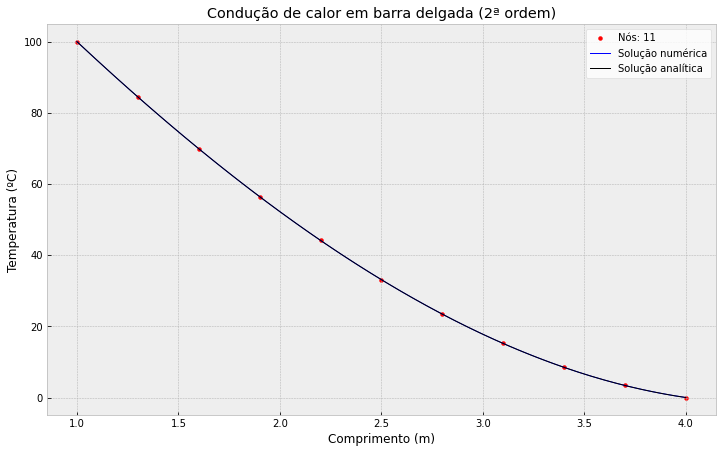

In [3]:
#Parâmetros Físicos

Xo = 1
Xf = 4
k = 5
To = 100
Tf = 0

def S(x):
    return (50/3)*(x+2)

#Parâmetros numéricos############################

#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.

ordemElemento = 2   #1 ou 2

ligacoes = 6                              
malha = np.linspace(Xo,Xf,ligacoes)

#################################################

##Produtos das funções de forma 1ª ordem
if ordemElemento == 1:

    ###Definindo nº de elementos e nós 
    nElementos = len(malha)-1
    nNos = nElementos+1
    
    nNosLocais = 2

    K11 = lambda x,X1,X2 : B11(x,X1,X2)*k*B11(x,X1,X2)
    K12 = lambda x,X1,X2 : B11(x,X1,X2)*k*B12(x,X1,X2)
    K21 = lambda x,X1,X2 : B12(x,X1,X2)*k*B11(x,X1,X2)
    K22 = lambda x,X1,X2 : B12(x,X1,X2)*k*B12(x,X1,X2)

    G1 = lambda x,X1,X2 : S(x)*N11(x,X1,X2)
    G2 = lambda x,X1,X2 : S(x)*N12(x,X1,X2)

    ###Função de integração a ser usada
    def INTEGRACAO_1(f,X1,X2):
        return sp.integrate.quad(f,X1,X2,(X1,X2))[0]

##Integrando e montando
    listaKe = np.empty((2,2,nElementos))
    listaGe = np.empty((1,2,nElementos))

    for e in range(0,nElementos):
        Ke = np.array([[INTEGRACAO_1(K11,malha[e],malha[e+1]),INTEGRACAO_1(K12,malha[e],malha[e+1])],
                    [INTEGRACAO_1(K21,malha[e],malha[e+1]),INTEGRACAO_1(K22,malha[e],malha[e+1])]])         

        Ge = np.array([[INTEGRACAO_1(G1,malha[e],malha[e+1]),INTEGRACAO_1(G2,malha[e],malha[e+1])]])

        listaKe[:,:,e] = Ke
        listaGe[:,:,e] = Ge


##Produtos das funções de forma 2ª ordem
elif ordemElemento == 2:
    
    ###Definindo nº de elementos e nós
    nElementos = int(len(malha)-1)
    nNos = nElementos + 1 + nElementos
    nNosLocais = 3

    ###MalhaPLT (Malha para plotagem (com os pontos intermediários de cada elemento))
    malhaPlot_e0 = np.array([malha[0],(malha[0]+malha[1])/2,malha[1]])   #1º elemento
    
    malhaPlot = np.empty(nNos-3)  #demais elementos

    for i in range(1,nElementos):

        nosElemento = np.array([(malha[i]+malha[i+1])/2, malha[i+1]])  
        malhaPlot[2*(i-1):2*(i)] = nosElemento

    malhaPLT = np.concatenate((malhaPlot_e0,malhaPlot))

    K11 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K12 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K13 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K21 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K22 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K23 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K31 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K32 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K33 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B23(x,X1,X2,X3)

    G1 = lambda x,X1,X2,X3 : S(x)*N21(x,X1,X2,X3)
    G2 = lambda x,X1,X2,X3 : S(x)*N22(x,X1,X2,X3)
    G3 = lambda x,X1,X2,X3 : S(x)*N23(x,X1,X2,X3)

    ###Função de integração a ser usada
    def INTEGRACAO_2(f,X1,X2,X3):
        return sp.integrate.quad(f,X1,X3,(X1,X2,X3))[0]

##Integrando e montando
    listaKe = np.empty((3,3,nElementos))
    listaGe = np.empty((1,3,nElementos))
    
    indice_elemento = 0
    for e in range(0,nElementos):

        no_medio = (malha[e]+malha[e+1])/2
        Ke = np.array([[INTEGRACAO_2(K11,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K12,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K13,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(K21,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K22,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K23,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(K31,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K32,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K33,malha[e],no_medio,malha[e+1])]])
            
        Ge = np.array([[INTEGRACAO_2(G1,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G2,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G3,malha[e],no_medio,malha[e+1])]])

        listaKe[:,:,indice_elemento] = Ke
        listaGe[:,:,indice_elemento] = Ge
        indice_elemento = indice_elemento + 1

# Matriz de conectividade (IEN)

IEN = np.zeros((nElementos,nNosLocais))

##1ª ORDEM
if ordemElemento == 1:
        
    for elemento in range(nElementos):
        for noLocal in range(nNosLocais):
                
            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

##2ª ORDEM
elif ordemElemento == 2:
    for elemento in range(nElementos):

        for noLocal in range(nNosLocais):

            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

print("Matriz de conectividade: ")
print(IEN)

#Matrizes globais

Ks = np.zeros((nNos,nNos))    #Ks pois se refere a matriz global ainda em seu estado singular
Gs= np.zeros(nNos)

nMatrizesElementares = len(listaKe[0,0,:])

##1ª ORDEM
if ordemElemento == 1:

    ###Adicionando cada matriz elementar à matriz global
    for K_elementar_index in range(nMatrizesElementares):

        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(2):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
        #print(Gaux)
        Gs = Gs + Gaux
        
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
##2ª ORDEM
elif ordemElemento == 2:

    ###Adicionando cada matriz elementar Ke à matriz global K
    for K_elementar_index in range(nMatrizesElementares):
        
        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
        
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(3):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

        Gs = Gs + Gaux
    
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
#Aplicação das condições de contorno na matriz e vetor independente:   K.T + G = 0

##K
###1º contorno
K = np.delete(Ks,obj=0,axis=0)   #eliminando linha
K = np.delete(K,obj=0, axis=1)   #eliminando coluna
###2º contorno
K = np.delete(K,obj=-1, axis=0)    #eliminando linha
K = np.delete(K,obj=-1, axis=1)   #eliminando coluna

##G
G = Gs[1:-1]
KLinhaEliminada = np.delete(Ks,obj=0,axis=0)
KLinhaEliminada = np.delete(KLinhaEliminada,obj=-1,axis=0)

for i in range(len(G)):

    G[i] = G[i] + To*KLinhaEliminada[i,0] + Tf*KLinhaEliminada[i,-1]

print("\nMatrizes globais: ")
print("K")  
print(np.array_str(K, precision=2, suppress_small=True))
print("G")
print(np.array_str(G, precision=2, suppress_small=True))

#Solucionando o sistema##########################

CampoTSemContorno = np.linalg.solve(K,-G)

BCo = np.array([To])
BCf = np.array([Tf])
Tnos = np.concatenate((BCo,CampoTSemContorno,BCf))

print("\nNós (solução numérica): ")
print(np.array_str(Tnos, precision=2, suppress_small=True))

#Gerando o campo de temperatura##################

def CampoTNumerico(malha,T):
    
    if ordemElemento == 1:
        np_e = 10   #nº de pontos que a interpolação calculará no interior de cada elemento

        #Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        #Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ##1º elemento
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N11(Dom_interpol_e0,malha[0],malha[0+1])*T[0] + N12(Dom_interpol_e0,malha[0],malha[0+1])*T[0+1])
        
        ##demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))
        
        for i in range(1, nElementos):

            Dom_interpol_e = np.linspace(malha[i], malha[i+1], np_e)
            npDom = len(Dom_interpol_e)
            
            S = N11(Dom_interpol_e,malha[i],malha[i+1])*T[i] + N12(Dom_interpol_e,malha[i],malha[i+1])*T[i+1]
             
            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = S[1:]
        
        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T
    
    elif ordemElemento == 2:
        np_e = 10   #nº de pontos que a interpolação calculará no interior de cada elemento

        #Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        #Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ##1º elemento
        no_medio_e0 = (malha[0]+malha[1])/2
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N21(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0] 
                             + N22(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+1] 
                             + N23(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+2])
        
        ##demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))

        for i in range(1,nElementos):

            no_medio = (malha[i]+malha[i+1])/2
            
            Dom_interpol_e = np.linspace(malha[i],malha[i+1],np_e)
            npDom = len(Dom_interpol_e)
            
            S = np.array(N21(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i] 
                       + N22(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+1] 
                       + N23(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+2])

            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*i] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*i] = S[1:]

        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T

#Solução analítica

Dom_analitica = np.linspace(Xo,Xf,500)

def CampoTAnalitico(x):
    return (5/9)*x**3 + (10/3)*x**2 - (185/3)*x + 1420/9

#Exibindo as soluções

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex = True, figsize = (12,7.2))

if ordemElemento == 1:

    ax1.scatter(malha, Tnos, s=15, color='red', label=r'Nós: {}'.format(nNos))
    ax1.plot(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', linewidth=1.0, label=r'Solução numérica')
    #ax1.scatter(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', s=15, label=r'Solução numérica')
    ax1.plot(Dom(240), CampoTAnalitico(Dom(240)), color='black', linewidth=1.0, label=r'Solução analítica')
    ax1.set_title('Condução de calor em barra delgada (1ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')


elif ordemElemento == 2:

    ax1.scatter(malhaPLT, Tnos, s=15, color='red', label=r'Nós: {}'.format(nNos))
    ax1.plot(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', linewidth=1.0, label=r'Solução numérica')
    #ax1.scatter(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', s=15, label=r'Solução numérica')
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0, label=r'Solução analítica')
    ax1.set_title('Condução de calor em barra delgada (2ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')

### Usando matrizes prontas (para elementos de 1ª e 2ª ordem em malhas uniformes e estruturadas)

Matriz de conectividade: 
[[0. 1.]
 [1. 2.]
 [2. 3.]
 [3. 4.]
 [4. 5.]]

Matrizes globais: 
K
[[16.67 -8.33  0.    0.  ]
 [-8.33 16.67 -8.33  0.  ]
 [ 0.   -8.33 16.67 -8.33]
 [ 0.    0.   -8.33 16.67]]
G
[-797.33   42.     48.     54.  ]

Nós (solução numérica): 
[100.    69.92  44.16  23.44   8.48   0.  ]


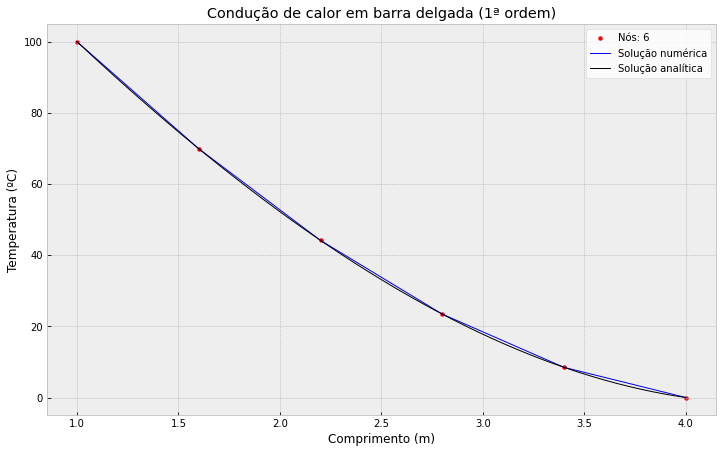

In [4]:
#Parâmetros Físicos#############################

Xo = 1
Xf = 4
A = 1
k = 5
To = 100
Tf = 0

def S(x):
    return (50/3)*(x+2)

#Parâmetros numéricos############################

#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.

ordemElemento = 1   #1 ou 2

ligacoes = 6        
malha = np.linspace(Xo,Xf,ligacoes)

#################################################

##Produtos das funções de forma 1ª ordem#########
if ordemElemento == 1:

    ###Definindo nº de elementos e nós 
    nElementos = len(malha)-1
    nNos = nElementos+1
    h = malha[1] - malha[0]
    nNosLocais = 2

    G1 = lambda x,X1,X2 : S(x)*N11(x,X1,X2)
    G2 = lambda x,X1,X2 : S(x)*N12(x,X1,X2)

    ###Função de integração a ser usada
    def INTEGRACAO_1(f,X1,X2):
        return sp.integrate.quad(f,X1,X2,(X1,X2))[0]

##Matrizes elementares
    listaKe = np.ones((2,2,nElementos))
    listaGe = np.ones((1,2,nElementos))

    Ke = (k/h)*np.array([[1,-1],[-1,1]]) 

    for e in range(0,nElementos):      

        Ge = np.array([[INTEGRACAO_1(G1,malha[e],malha[e+1]),INTEGRACAO_1(G2,malha[e],malha[e+1])]])
    
        listaKe[:,:,e] = Ke
        listaGe[:,:,e] = Ge


##Produtos das funções de forma 2ª ordem#########
elif ordemElemento == 2:

    ###Definindo nº de elementos e nós
    nElementos = int(len(malha)-1)
    nNos = nElementos + 1 + nElementos
    h = malha[1] - malha[0]
    nNosLocais = 3

    ###MalhaPLT (Malha para plotagem (com os pontos intermediários de cada elemento))
    malhaPlot_e0 = np.array([malha[0],(malha[0]+malha[1])/2,malha[1]])   #1º elemento
    
    malhaPlot = np.empty(nNos-3)  #demais elementos

    for i in range(1,nElementos):
        
        nosElemento = np.array([(malha[i]+malha[i+1])/2, malha[i+1]])
        
        malhaPlot[2*(i-1):2*(i)] = nosElemento

    malhaPLT = np.concatenate((malhaPlot_e0,malhaPlot))

    G1 = lambda x,X1,X2,X3 : S(x)*N21(x,X1,X2,X3)
    G2 = lambda x,X1,X2,X3 : S(x)*N22(x,X1,X2,X3)
    G3 = lambda x,X1,X2,X3 : S(x)*N23(x,X1,X2,X3)

    ###Função de integração a ser usada
    def INTEGRACAO_2(f,X1,X2,X3):
        return sp.integrate.quad(f,X1,X3,(X1,X2,X3))[0]

##Matrizes elementares
    listaKe = np.empty((3,3,nElementos))
    listaGe = np.empty((1,3,nElementos))
    
    Ke = (k/(3*h))*np.array([[7,-8,1],[-8,16,-8],[1,-8,7]])

    indice_elemento = 0
    for e in range(0,nElementos):

        no_medio = (malha[e]+malha[e+1])/2
        Ge = np.array([[INTEGRACAO_2(G1,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G2,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G3,malha[e],no_medio,malha[e+1])]])

        listaKe[:,:,indice_elemento] = Ke
        listaGe[:,:,indice_elemento] = Ge
        indice_elemento = indice_elemento + 1

#Matriz de conectividade (IEN)###################

IEN = np.zeros((nElementos,nNosLocais))

##1ª ORDEM
if ordemElemento == 1:
        
    for elemento in range(nElementos):
        for noLocal in range(nNosLocais):
                
            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

##2ª ORDEM
elif ordemElemento == 2:
    for elemento in range(nElementos):

        for noLocal in range(nNosLocais):

            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

print("Matriz de conectividade: ")
print(IEN)

#Matrizes globais#################################

Ks = np.zeros((nNos,nNos))    #Ks pois se refere a matriz global ainda em seu estado singular
Gs= np.zeros(nNos)

nMatrizesElementares = len(listaKe[0,0,:])

##1ª ORDEM
if ordemElemento == 1:

    ###Adicionando cada matriz elementar à matriz global
    for K_elementar_index in range(nMatrizesElementares):

        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            Kaux[posicao_global] = Ke[posicoes_locais[i]]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(2):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
        #print(Gaux)
        Gs = Gs + Gaux
        
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
##2ª ORDEM
elif ordemElemento == 2:

    ###Adicionando cada matriz elementar Ke à matriz global K
    for K_elementar_index in range(nMatrizesElementares):
        
        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]

        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            Kaux[posicao_global] = Ke[posicoes_locais[i]]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(3):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

        Gs = Gs + Gaux
    
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
#Aplicação das condições de contorno na matriz e vetor independente:   K.T + G = 0

##K
###1º contorno
K = np.delete(Ks,obj=0,axis=0)   #eliminando linha
K = np.delete(K,obj=0, axis=1)   #eliminando coluna
###2º contorno
K = np.delete(K,obj=-1, axis=0)    #eliminando linha
K = np.delete(K,obj=-1, axis=1)   #eliminando coluna

##G
G = Gs[1:-1]
KLinhaEliminada = np.delete(Ks,obj=0,axis=0)
KLinhaEliminada = np.delete(KLinhaEliminada,obj=-1,axis=0)

for i in range(len(G)):

    G[i] = G[i] + To*KLinhaEliminada[i,0] + Tf*KLinhaEliminada[i,-1]

print("\nMatrizes globais: ")
print("K")  
print(np.array_str(K, precision=2, suppress_small=True))
print("G")
print(np.array_str(G, precision=2, suppress_small=True))

#Solucionando o sistema###########################

CampoTSemContorno = np.linalg.solve(K,-G)

BCo = np.array([To])
BCf = np.array([Tf])
Tnos = np.concatenate((BCo,CampoTSemContorno,BCf))

print("\nNós (solução numérica): ")
print(np.array_str(Tnos, precision=2, suppress_small=True))

#Gerando o campo de temperatura##################

def CampoTNumerico(malha,T):
    
    if ordemElemento == 1:
        np_e = 10   #nº de pontos que a interpolação calculará no interior de cada elemento

        #Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        #Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ##1º elemento
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N11(Dom_interpol_e0,malha[0],malha[0+1])*T[0] + N12(Dom_interpol_e0,malha[0],malha[0+1])*T[0+1])
        
        ##demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))
        
        for i in range(1, nElementos):

            Dom_interpol_e = np.linspace(malha[i], malha[i+1], np_e)
            npDom = len(Dom_interpol_e)
            
            S = N11(Dom_interpol_e,malha[i],malha[i+1])*T[i] + N12(Dom_interpol_e,malha[i],malha[i+1])*T[i+1]
             
            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = S[1:]
        
        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T
    
    elif ordemElemento == 2:
        np_e = 10   #nº de pontos que a interpolação calculará no interior de cada elemento

        #Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        #Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ##1º elemento
        no_medio_e0 = (malha[0]+malha[1])/2
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N21(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0] 
                             + N22(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+1] 
                             + N23(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+2])
        
        ##demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))

        for i in range(1,nElementos):

            no_medio = (malha[i]+malha[i+1])/2
            
            Dom_interpol_e = np.linspace(malha[i],malha[i+1],np_e)
            npDom = len(Dom_interpol_e)
            
            S = np.array(N21(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i] 
                       + N22(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+1] 
                       + N23(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+2])

            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*i] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*i] = S[1:]

        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T

#Solução analítica

Dom_analitica = np.linspace(Xo,Xf,500)

def CampoTAnalitico(x):
    return (5/9)*x**3 + (10/3)*x**2 - (185/3)*x + 1420/9

#Exibindo as soluções

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex = True, figsize = (12,7.2))

if ordemElemento == 1:

    ax1.scatter(malha, Tnos, s=15, color='red', label=r'Nós: {}'.format(nNos))
    ax1.plot(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', linewidth=1.0, label=r'Solução numérica')
    #ax1.scatter(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', s=15, label=r'Solução numérica')
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0, label=r'Solução analítica')
    ax1.set_title('Condução de calor em barra delgada (1ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')


elif ordemElemento == 2:

    ax1.scatter(malhaPLT, Tnos, s=15, color='red', label=r'Nós: {}'.format(nNos))
    ax1.plot(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', linewidth=1.0, label=r'Solução numérica')
    #ax1.scatter(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', s=15, label=r'Solução numérica')
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0, label=r'Solução analítica')
    ax1.set_title('Condução de calor em barra delgada (2ª ordem')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')


## Condução de calor em barra delgada em regime transiente

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Matriz de conectividade: 
[[ 0.  1.]
 [ 1.  2.]
 [ 2.  3.]
 [ 3.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 7.  8.]
 [ 8.  9.]
 [ 9. 10.]
 [10. 11.]
 [11. 12.]
 [12. 13.]
 [13. 14.]
 [14. 15.]
 [15. 16.]
 [16. 17.]
 [17. 18.]
 [18. 19.]
 [19. 20.]
 [20. 21.]
 [21. 22.]
 [22. 23.]
 [23. 24.]
 [24. 25.]
 [25. 26.]
 [26. 27.]
 [27. 28.]
 [28. 29.]]

Matrizes globais: 
K
[[ 96.67 -48.33   0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.  ]
 [-48.33  96.67 -48.33   0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.   -48.33  96.67 -48.33   0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.   -48.33  96.67 -48.3

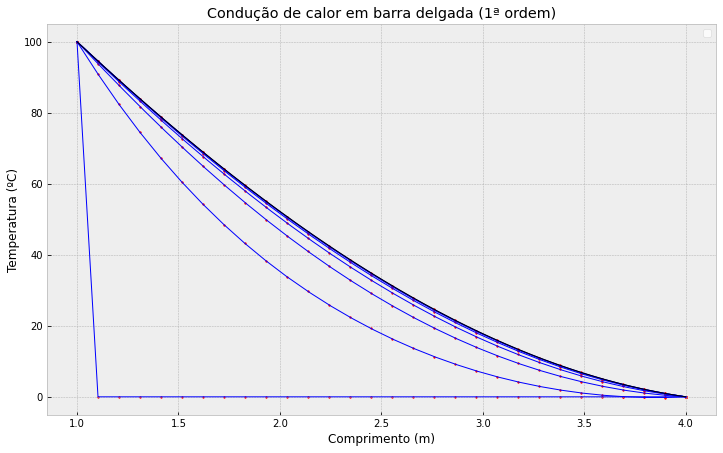

In [5]:
#Parâmetros Físicos

Xo = 1
Xf = 4
A = 1
k = 5
Tto = 0
To = 100
Tf = 0
to = 0
tf = 2
dt = 0.333
nt = int((tf-to)/dt+1)

def S(x):
    return (50/3)*(x+2)

#Parâmetros numéricos############################

#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.

ordemElemento = 1   #1 ou 2

ligacoes = 30                              
malha = np.linspace(Xo,Xf,ligacoes)

#################################################

##Produtos das funções de forma 1ª ordem
if ordemElemento == 1:

    ###Definindo nº de elementos e nós 
    nElementos = len(malha)-1
    nNos = nElementos+1
    
    nNosLocais = 2

    K11 = lambda x,X1,X2 : B11(x,X1,X2)*k*B11(x,X1,X2)
    K12 = lambda x,X1,X2 : B11(x,X1,X2)*k*B12(x,X1,X2)
    K21 = lambda x,X1,X2 : B12(x,X1,X2)*k*B11(x,X1,X2)
    K22 = lambda x,X1,X2 : B12(x,X1,X2)*k*B12(x,X1,X2)

    G1 = lambda x,X1,X2 : S(x)*N11(x,X1,X2)
    G2 = lambda x,X1,X2 : S(x)*N12(x,X1,X2)

    M11 = lambda x,X1,X2 : N11(x,X1,X2)*N11(x,X1,X2)
    M12 = lambda x,X1,X2 : N11(x,X1,X2)*N12(x,X1,X2)
    M21 = lambda x,X1,X2 : N12(x,X1,X2)*N11(x,X1,X2)
    M22 = lambda x,X1,X2 : N12(x,X1,X2)*N12(x,X1,X2)

    ###Função de integração a ser usada
    def INTEGRACAO_1(f,X1,X2):
        return sp.integrate.quad(f,X1,X2,(X1,X2))[0]

##Integrando e montando
    listaKe = np.empty((2,2,nElementos))
    listaGe = np.empty((1,2,nElementos))
    listaMe = np.empty((2,2,nElementos))

    for e in range(0,nElementos):
        Ke = np.array([[INTEGRACAO_1(K11,malha[e],malha[e+1]),INTEGRACAO_1(K12,malha[e],malha[e+1])],
                    [INTEGRACAO_1(K21,malha[e],malha[e+1]),INTEGRACAO_1(K22,malha[e],malha[e+1])]])    

        Ge = np.array([[INTEGRACAO_1(G1,malha[e],malha[e+1]),INTEGRACAO_1(G2,malha[e],malha[e+1])]])

        Me = np.array([[INTEGRACAO_1(M11,malha[e],malha[e+1]),INTEGRACAO_1(M12,malha[e],malha[e+1])],
                    [INTEGRACAO_1(M21,malha[e],malha[e+1]),INTEGRACAO_1(M22,malha[e],malha[e+1])]]) 

        listaKe[:,:,e] = Ke
        listaGe[:,:,e] = Ge
        listaMe[:,:,e] = Me


##Produtos das funções de forma 2ª ordem
elif ordemElemento == 2:
    
    ###Definindo nº de elementos e nós
    nElementos = int(len(malha)-1)
    nNos = nElementos + 1 + nElementos
    nNosLocais = 3

    ###MalhaPLT (Malha para plotagem (com os pontos intermediários de cada elemento))
    malhaPlot_e0 = np.array([malha[0],(malha[0]+malha[1])/2,malha[1]])   #1º elemento
    
    malhaPlot = np.empty(nNos-3)  #demais elementos

    for i in range(1,nElementos):

        nosElemento = np.array([(malha[i]+malha[i+1])/2, malha[i+1]])  
        malhaPlot[2*(i-1):2*(i)] = nosElemento

    malhaPLT = np.concatenate((malhaPlot_e0,malhaPlot))

    K11 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K12 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K13 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K21 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K22 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K23 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K31 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K32 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K33 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B23(x,X1,X2,X3)

    G1 = lambda x,X1,X2,X3 : S(x)*N21(x,X1,X2,X3)
    G2 = lambda x,X1,X2,X3 : S(x)*N22(x,X1,X2,X3)
    G3 = lambda x,X1,X2,X3 : S(x)*N23(x,X1,X2,X3)

    M11 = lambda x,X1,X2,X3 : N21(x,X1,X2,X3)*N21(x,X1,X2,X3)
    M12 = lambda x,X1,X2,X3 : N21(x,X1,X2,X3)*N22(x,X1,X2,X3)
    M13 = lambda x,X1,X2,X3 : N21(x,X1,X2,X3)*N23(x,X1,X2,X3)
    M21 = lambda x,X1,X2,X3 : N22(x,X1,X2,X3)*N21(x,X1,X2,X3)
    M22 = lambda x,X1,X2,X3 : N22(x,X1,X2,X3)*N22(x,X1,X2,X3)
    M23 = lambda x,X1,X2,X3 : N22(x,X1,X2,X3)*N23(x,X1,X2,X3)
    M31 = lambda x,X1,X2,X3 : N23(x,X1,X2,X3)*N21(x,X1,X2,X3)
    M32 = lambda x,X1,X2,X3 : N23(x,X1,X2,X3)*N22(x,X1,X2,X3)
    M33 = lambda x,X1,X2,X3 : N23(x,X1,X2,X3)*N23(x,X1,X2,X3)

    ###Função de integração a ser usada
    def INTEGRACAO_2(f,X1,X2,X3):
        return sp.integrate.quad(f,X1,X3,(X1,X2,X3))[0]

##Integrando e montando
    listaKe = np.empty((3,3,nElementos))
    listaGe = np.empty((1,3,nElementos))
    listaMe = np.empty((3,3,nElementos))

    '''Há um if dentro do loop porque elementos de 2ª ordem podem terminar incompletos dependendo de como discretizarmos o domínio. Dessa forma é 
    necessário definir uma integração particular para o último elemento em que o integramos só até a metade'''
    
    indice_elemento = 0
    for e in range(0,nElementos):

        no_medio = (malha[e]+malha[e+1])/2
        Ke = np.array([[INTEGRACAO_2(K11,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K12,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K13,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(K21,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K22,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K23,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(K31,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K32,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K33,malha[e],no_medio,malha[e+1])]])
            
        Ge = np.array([[INTEGRACAO_2(G1,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G2,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G3,malha[e],no_medio,malha[e+1])]])
        
        Me = np.array([[INTEGRACAO_2(M11,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M12,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M13,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(M21,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M22,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M23,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(M31,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M32,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M33,malha[e],no_medio,malha[e+1])]])

        listaKe[:,:,indice_elemento] = Ke
        listaGe[:,:,indice_elemento] = Ge
        listaMe[:,:,indice_elemento] = Me
        indice_elemento = indice_elemento + 1

# Matriz de conectividade (IEN)

IEN = np.zeros((nElementos,nNosLocais))

## 1ª ORDEM
if ordemElemento == 1:
        
    for elemento in range(nElementos):
        for noLocal in range(nNosLocais):
                
            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

## 2ª ORDEM
elif ordemElemento == 2:
    for elemento in range(nElementos):

        for noLocal in range(nNosLocais):

            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

print("Matriz de conectividade: ")
print(IEN)

# Matrizes globais

Ks = np.zeros((nNos,nNos))    #Ks pois se refere a matriz global ainda em seu estado singular
Gs = np.zeros(nNos)
Ms = np.zeros((nNos,nNos))
nMatrizesElementares = len(listaKe[0,0,:])

## 1ª ORDEM
if ordemElemento == 1:

    ###Adicionando cada matriz elementar à matriz global
    for K_elementar_index in range(nMatrizesElementares):

        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(2):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
        #print(Gaux)
        Gs = Gs + Gaux

    for M_elementar_index in range(nMatrizesElementares):

        Maux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[M_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            posicao_local = posicoes_locais[i] + (M_elementar_index,)
            Maux[posicao_global] = listaMe[posicao_local]
        #print(Maux)
        Ms = Ms + Maux
        
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
## 2ª ORDEM
elif ordemElemento == 2:

    ###Adicionando cada matriz elementar Ke à matriz global K
    for K_elementar_index in range(nMatrizesElementares):
        
        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
        
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(3):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

        Gs = Gs + Gaux
    
    for M_elementar_index in range(nMatrizesElementares):
        
        Maux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[M_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
        
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            posicao_local = posicoes_locais[i] + (M_elementar_index,)
            Maux[posicao_global] = listaMe[posicao_local]
        #print(Maux)
        Ms = Ms + Maux

    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
# Aplicação das condições de contorno na matriz e vetor independente:   K.T + G = 0

##K
###1º contorno
K = np.delete(Ks,obj=0,axis=0)   #eliminando linha
K = np.delete(K,obj=0, axis=1)   #eliminando coluna

M = np.delete(Ms,obj=0,axis=0)   #eliminando linha
M = np.delete(M,obj=0, axis=1)   #eliminando coluna
###2º contorno
K = np.delete(K,obj=-1, axis=0)    #eliminando linha
K = np.delete(K,obj=-1, axis=1)   #eliminando coluna

M = np.delete(M,obj=-1, axis=0)    #eliminando linha
M = np.delete(M,obj=-1, axis=1)   #eliminando coluna

##G
G = Gs[1:-1]
KLinhaEliminada = np.delete(Ks,obj=0,axis=0)
KLinhaEliminada = np.delete(KLinhaEliminada,obj=-1,axis=0)

for i in range(len(G)):

    G[i] = G[i] + To*KLinhaEliminada[i,0] + Tf*KLinhaEliminada[i,-1]

print("\nMatrizes globais: ")
print("K")  
print(np.array_str(K, precision=2, suppress_small=True))
print("\nG")
print(np.array_str(G, precision=2, suppress_small=True))
print("\nM")
print(np.array_str(M, precision=2, suppress_small=True))

# Solucionando o sistema##########################

campos = np.empty((nNos,nt))

## Condição inicial
campo0 = Tto*np.ones(nNos-2)
BCo = np.array([To])
BCf = np.array([Tf])
campo0 = np.concatenate((BCo,campo0,BCf))

campos[:,0] = campo0

## Demais instantes 
A = M/dt + K    # Formatando na forma A.T = b

for n in range(1,nt):

    b = M/dt@campos[1:-1,n-1] - G     # Formatando na forma A.T = b
    
    CampoTSemContorno = np.linalg.solve(A,b)

    BCo = np.array([To])
    BCf = np.array([Tf])
    campo = np.concatenate((BCo,CampoTSemContorno,BCf))
    print(campo)
    campos[:,n] = campo

# Gerando o campo de temperatura##################

def CampoTNumerico(malha,T):
    
    if ordemElemento == 1:
        np_e = 10   # nº de pontos que a interpolação calculará no interior de cada elemento

        # Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        # Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ## 1º elemento
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N11(Dom_interpol_e0,malha[0],malha[0+1])*T[0] + N12(Dom_interpol_e0,malha[0],malha[0+1])*T[0+1])
        
        ## demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))
        
        for i in range(1, nElementos):

            Dom_interpol_e = np.linspace(malha[i], malha[i+1], np_e)
            npDom = len(Dom_interpol_e)
            
            S = N11(Dom_interpol_e,malha[i],malha[i+1])*T[i] + N12(Dom_interpol_e,malha[i],malha[i+1])*T[i+1]
             
            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = S[1:]
        
        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T
    
    elif ordemElemento == 2:
        np_e = 10   # nº de pontos que a interpolação calculará no interior de cada elemento

        # Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        # Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ## 1º elemento
        no_medio_e0 = (malha[0]+malha[1])/2
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N21(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0] 
                             + N22(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+1] 
                             + N23(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+2])
        
        ## demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))

        for i in range(1,nElementos):

            no_medio = (malha[i]+malha[i+1])/2
            
            Dom_interpol_e = np.linspace(malha[i],malha[i+1],np_e)
            npDom = len(Dom_interpol_e)
            
            S = np.array(N21(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i] 
                       + N22(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+1] 
                       + N23(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+2])

            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*i] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*i] = S[1:]

        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T

#Solução analítica estacionária

Dom_analitica = np.linspace(Xo,Xf,500)

def CampoTAnalitico(x):
    return (5/9)*x**3 + (10/3)*x**2 - (185/3)*x + 1420/9

#Exibindo as soluções

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex = True, figsize = (12,7.2))

if ordemElemento == 1:

    for n in range(0,nt):

        ax1.scatter(malha, campos[:,n], s=3.0, color='red')
        ax1.plot(CampoTNumerico(malha,campos[:,n])[0], CampoTNumerico(malha,campos[:,n])[1], color='blue', linewidth=1.0)
    
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0)

    ax1.set_title('Condução de calor em barra delgada (1ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')


elif ordemElemento == 2:

    for n in range(0,nt):

        ax1.scatter(malhaPLT, campos[:,n], s=3.0, color='red')
        ax1.plot(CampoTNumerico(malha,campos[:,n])[0], CampoTNumerico(malha,campos[:,n])[1], color='blue', linewidth=1.0)
    
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0)
    
    ax1.set_title('Condução de calor em barra delgada (2ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')

## Condução de calor em barra delgada em regime transiente $\\$ (script proposto em aula - EEK597)

Neste script é usado o método **implícito acoplado**. Note como neste código a matriz global é montada de maneira muito mais intuitiva.

**Obs.: para método explícito e crank-nicholson, quanto maior $\Delta x$, menor deve ser o $\Delta t$ para que haja convergência do algoritmo**

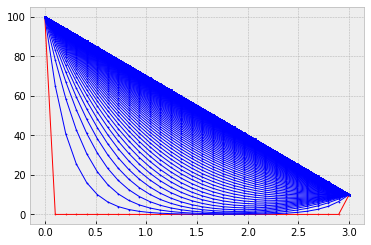

In [6]:
# parametros da simulacao

L = 3.0
nx = 30
ne = nx-1
Te = 100
Td = 10
k = 5.0
#rho = 1.0
#cv = 1.0
alpha = 5.0     #k/(rho*cv)
to = 0
tf = 2
dt = 0.01
nt = int((tf-to)/dt+1)
Q = 0

def S(x):
    return (50/3)*(x+2)

#beta = 0.0 # metodo explicito
beta = 1.0 # metodo implicito
#beta = 0.5 # metodo Crank-Nicolson

# geracao de malha 1D
X = np.linspace(0,L,nx)

IEN = np.zeros( (ne,2),dtype='int' )
for e in range(0,ne):
 IEN[e] = [e,e+1]

# lista de indices de condicao de contorno
cc = [0,nx-1]

# vetor com valores das condicoes de contorno
Tcc = np.zeros( (nx),dtype='float' )
Tcc[0] = Te
Tcc[-1] = Td
 
# inicializacao das matrizes globais
K = np.zeros( (nx,nx),dtype='float' )
M = np.zeros( (nx,nx),dtype='float' )

for e in range(0,ne):
 v1,v2 = IEN[e]
 h = X[v2]-X[v1]
 kelem = (alpha/h)*np.array([[ 1.0,-1.0],
                             [-1.0, 1.0]])
 melem = (h/6.0)*np.array([[ 2.0, 1.0],
                           [ 1.0, 2.0]])
 for ilocal in range(0,2):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,2):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]

# definicao da condicao inicial
T = np.zeros( (nx),dtype='float' )
for i in cc:
 T[i] = Tcc[i]
plt.scatter(X,T,s=1.5,color='r')
plt.plot(X,T,'r-',linewidth=1.0)

# definicao do sistema linear
qvec = (alpha*Q/k)*np.ones( (nx),dtype='float' )

##A = M/dt + K        # metodo implicito para difusao (beta = 1)
##A = M/dt            # metodo explicito para difusao (beta = 0)
##A = M/dt + beta*K   # metodo hibrido para difusao   (beta = 0.5)

A = M/dt + beta*K

# imposicao das c.c.s de Dirichlet na matriz A
for i in cc:
 A[i,:] = 0.0 # zerar linha
 A[i,i] = 1.0 # incluir 1 na diagonal

# recorrência temporal
for n in range(0,nt):
 ##b = (M/dt)@T + M@qvec                  # metodo implicito para difusao (beta = 1)
 ##b = (M/dt - K)@T + M@qvec              # metodo explicito para difusao (beta = 0)
 ##b = (M/dt - (1.0-beta)*K)@T + M@qvec   # metodo hibrido para difusao   (beta = 0.5)

 b = (M/dt - (1.0-beta)*K)@T + M@qvec

 # imposicao das c.c.s de Dirichlet no vetor b
 for i in cc:
  b[i]   = Tcc[i]

 # temperatura em n+1
 T = np.linalg.solve(A,b)

 plt.scatter(X,T,s=1.5,color='b')
 plt.plot(X,T,'b-',linewidth=1.0)
plt.show()

## Condução de calor bidimensional

### Condução de calor estacionária em placa plana com lados em condição de Dirichlet

#### Gerando própria malha

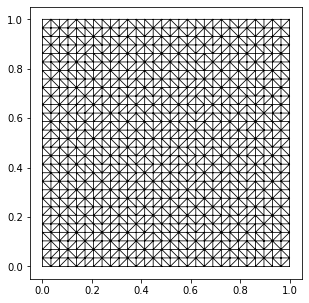

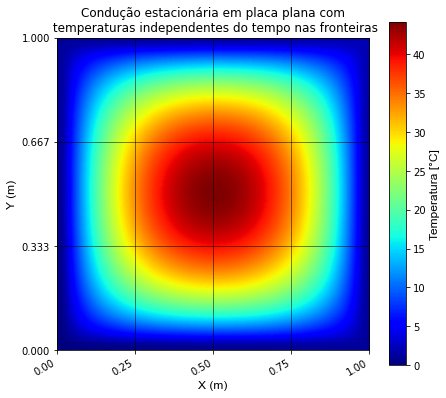

In [94]:
Lx = 1
Ly = 1
nx = 30
ny = 30
k = 34.0
Q = 20000.0

# Geração de:
## pontos

nVerts = nx*ny

#criando lista de todos os pontos
for i in range(0,nVerts):
    nVerts_array[i] = i

## elementos
ne = 2*(nx-1)*(ny-1) # triangulo
IEN = np.zeros( (ne,3),dtype='int' )   #Empty IEN

Xv = np.linspace(0,Lx,nx)
Yv = np.linspace(0,Ly,ny)
X,Y = np.meshgrid(Xv,Yv)   #Gera matrizes (ny,nx)
X = np.reshape(X,nVerts)
Y = np.reshape(Y,nVerts)

TRI = Delaunay(np.column_stack((X,Y)))   #np.column_stack torna vetores colunas de uma matriz
IEN = TRI.simplices.copy()               #o método simplices retorna a IEN da malha gerado pelo Delaunay
numElems = IEN.shape[0]

bound1 = []
bound2 = []
bound3 = []
bound4 = []

for i in range(0,nx):           #lado inferior          #    x x x x x x x
    bound1.append(i)                                    #    y           y
for i in range(2,ny):           #lado direito           #    y           y
    bound2.append(i*nx - 1)                             #    y           y
for i in nVerts_array[-nx:]:    #lado superior          #    y           y
    bound3.append(i)                                    #    y           y
for i in range(1,ny-1):         #lado esquerdo          #    x x x x x x x
    bound4.append(i*nx)

Tcc = np.zeros( (nVerts),dtype='float' )

# caso sejam dirichlet:         # veja que variam com o espaço
for i in bound1:                #lado inferior 
    Tcc[i] = X[i]
    #Tcc[i] = 30 


for i in bound2:                #lado direito
    Tcc[i] = Y[i]*Y[i] + 1
    #Tcc[i] = 25

# cc3 (caso seja dirichlet)
for i in bound3:                #lado superior
    Tcc[i] = X[i]*X[i] + 1
    #Tcc[i] = 30

# cc4 (caso seja dirichlet)
for i in bound4:                #lado esquerdo
    Tcc[i] = Y[i]
    #Tcc[i] = 90

IENbound = bound1 + bound2 + bound3 + bound4

# vetor de áreas de cada elemento
area = np.empty(ne)
e = 0
for i in range(0,ny-1):
    for j in range(0,nx-1):

        lado1 = np.array([ X[i*nx+j+nx]-X[i*nx+j], Y[i*nx+j+nx]-Y[i*nx+j] ])
        lado2 = np.array([ X[i*nx+j+1]-X[i*nx+j], Y[i*nx+j+1]-Y[i*nx+j] ])
        diagonal = np.array([ X[i*nx+j+nx+1]-X[i*nx+j], Y[i*nx+j+nx+1]-Y[i*nx+j] ])

        A_tri1 = np.linalg.norm(np.cross(lado1,diagonal))/2
        area[e] = A_tri1
        e += 1

        A_tri2 = np.linalg.norm(np.cross(lado2,diagonal))/2
        area[e] = A_tri2
        e += 1

# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (nVerts,nVerts),dtype='float' )
M = np.zeros( (nVerts,nVerts),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = k*((1/(4*area[e]))*kxelem + (1/(4*area[e]))*kyelem)

 melem = (area[e]/12.0)*np.array([[2.0,1.0,1.0],
                                  [1.0,2.0,1.0],
                                  [1.0,1.0,2.0]])
 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]

A = K.copy()

qvec = Q*np.ones( (nVerts),dtype='float' )
b = M@qvec

#imposicao das c.c.s de Dirichlet
for i in IENbound:
 A[i,:] = 0.0
 A[i,i] = 1.0
 b[i] = Tcc[i]

T = np.linalg.solve(A,b)

#--------------------------------------------------
#fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# plotando malha
fig, ax1 = plt.subplots(figsize = (5,5))

triang = mtri.Triangulation(X,Y,IEN)
ax1.set_aspect('equal')
ax1.triplot(triang,'k-', linewidth=0.8)

# plotando gráfico
fig, ax2 = plt.subplots(figsize = (7,7))

'''
triang = mtri.Triangulation(X,Y,IEN)
ax2.set_aspect('equal')
ax2.tricontourf(triang,T, interpolation='quadric', origin='lower', cmap=cm.jet)
cbar = plt.colorbar(ax2.tricontourf(triang,T,cmap=cm.jet),shrink=1.0, aspect=20)
'''

T = T.reshape(ny,nx)                                                 # plot com imshow é melhor renderizado
surf = ax2.imshow(T, interpolation='quadric', origin='lower',
            cmap=cm.jet, extent=(X.min(), X.max(), Y.min(), Y.max()))
cbar = plt.colorbar(surf,shrink=1.0, aspect=20)


cbar.set_label('Temperatura [°C]',fontdict=matplot_font)
plt.title("Condução estacionária em placa plana com\n temperaturas independentes do tempo nas fronteiras")
plt.ylabel("Y (m)",fontdict=matplot_font) 
plt.xlabel("X (m)",fontdict=matplot_font) 
labx = np.linspace(X.min(),X.max(),5)
laby = np.linspace(Y.min(),Y.max(),4)
plt.grid(color='black', linestyle='solid', linewidth=0.5)
plt.xticks(labx)
plt.yticks(laby)
plt.gcf().autofmt_xdate()
plt.show()



#### Importando malha do *gmsh*

C:\Users\jferreira\AppData\Local\Temp\ipykernel_24376\328486991.py:130: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax1.tricontourf(triang,T, interpolation='quadric', origin='lower', cmap=cm.jet)


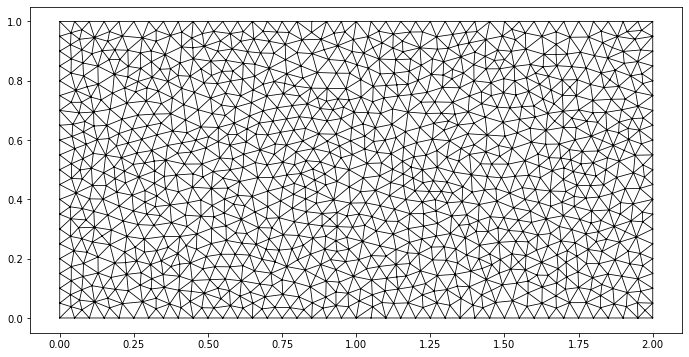

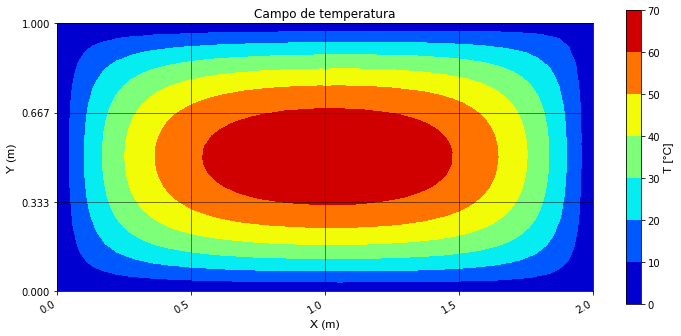

'\npoint_data = {\'Temperatura\' : T}\ndata_Tcc = {\'T_contorno\' : Tcc}\npoint_data.update(data_Tcc)\nmeshio.write_points_cells(\'solucao.vtk\',\n                          msh.points, \n                          msh.cells,\n                          file_format="vtk-ascii",\n                          point_data=point_data,\n                          )\n\n'

In [130]:
import meshio

# parâmetros físicos
k = 34.0
Q = 20000.0

# leitura de malha e classificacao de contorno por nome (ccName)
msh = meshio.read(r'C:\Users\jferreira\Downloads\ElementosFinitos\Retangulo.msh')   #meshio.read('C:\Users\João Pedro\Downloads\ElementosFinitos\Retangulo.msh')
X = np.array(msh.points)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 5)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Admissao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'Exaustao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'CCSuperior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'CCInferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]


# valor de condicao de contorno
Tcc = np.zeros( (npoints),dtype='float' )
for i in cc:
 if ccName[i] == 'CCInferior':
  Tcc[i] = X[i]
 elif ccName[i] == 'CCSuperior':
  Tcc[i] = X[i]*X[i] + 1
 elif ccName[i] == 'Exaustao':
  Tcc[i] = Y[i]*Y[i] + 1
 elif ccName[i] == 'Admissao':
  Tcc[i] = Y[i]


# inicializacao das matrizes globais
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = k*((1/(4*area))*kxelem + (1/(4*area))*kyelem)

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])
 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]

A = K.copy()

qvec = Q*np.ones( (npoints),dtype='float' )
b = M@qvec


# imposicao das c.c.s de Dirichlet
for i in cc:
  if ccName[i] == 'CCSuperior' or \
     ccName[i] == 'CCInferior' or \
     ccName[i] == 'Admissao' or \
     ccName[i] == 'Exaustao':
      A[i,:] = 0.0
      A[i,i] = 1.0
      b[i] = Tcc[i]

T = np.linalg.solve(A,b)


# plot

fig, ax0 = plt.subplots(figsize = (12,6))

triang = mtri.Triangulation(X,Y,IEN)
ax0.set_aspect('equal')
ax0.triplot(triang,'k-', linewidth=0.8)

fig, ax1 = plt.subplots(figsize = (12,6))

triang = mtri.Triangulation(X,Y,IEN)
ax1.set_aspect('equal')
ax1.tricontourf(triang,T, interpolation='quadric', origin='lower', cmap=cm.jet)
cbar = plt.colorbar(ax1.tricontourf(triang,T,cmap=cm.jet),shrink=1.0, aspect=20)

cbar.set_label('T [°C]',fontdict=matplot_font)
plt.title("Campo de temperatura")
plt.ylabel("Y (m)",fontdict=matplot_font) 
plt.xlabel("X (m)",fontdict=matplot_font) 
labx = np.linspace(X.min(),X.max(),5)
laby = np.linspace(Y.min(),Y.max(),4)
plt.grid(color='black', linestyle='solid', linewidth=0.5)
plt.xticks(labx)
plt.yticks(laby)
plt.gcf().autofmt_xdate()

plt.show()

'''
point_data = {'Temperatura' : T}
data_Tcc = {'T_contorno' : Tcc}
point_data.update(data_Tcc)
meshio.write_points_cells('solucao.vtk',
                          msh.points, 
                          msh.cells,
                          file_format="vtk-ascii",
                          point_data=point_data,
                          )

'''
#--------------------------------------------------
# import matplotlib.tri as mtri
# triang = mtri.Triangulation(X,Y,IEN)
# ax = plt.axes()
# ax.set_aspect('equal')
# ax.triplot(triang,'k-')
# ax.tricontourf(triang,T,cmap='jet')
# plt.show()
#-------------------------------------------------- 

### Condução de calor transiente em placa plana com lados em condição de Dirichlet

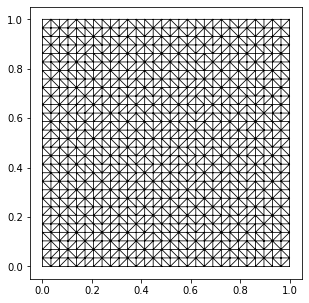

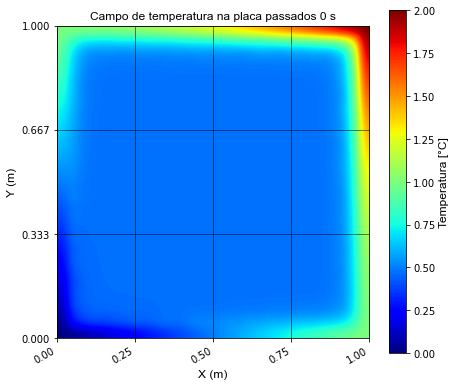

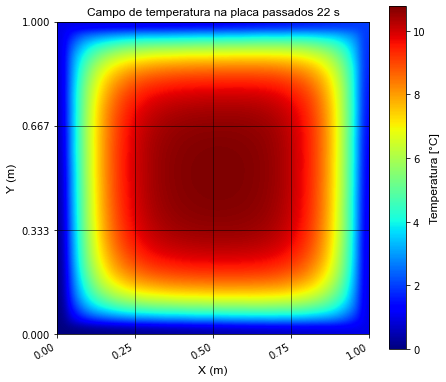

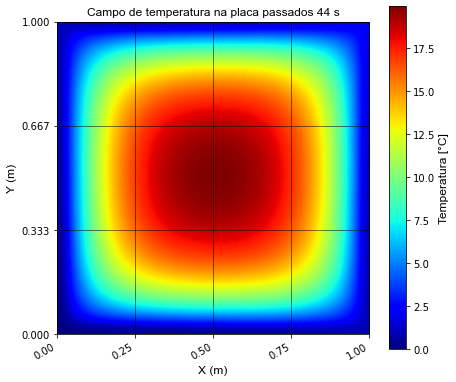

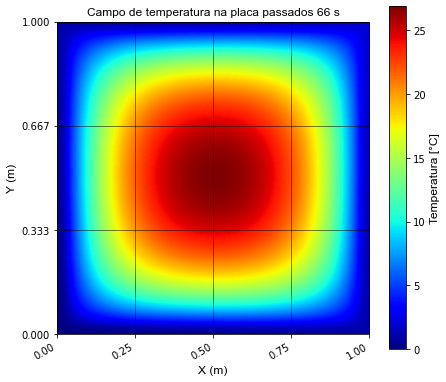

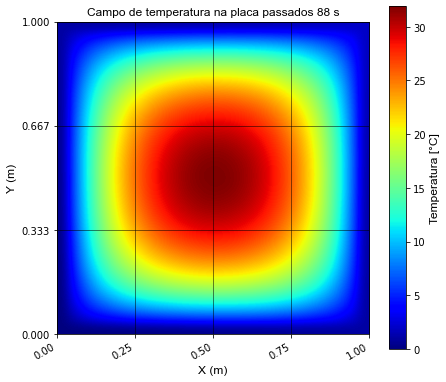

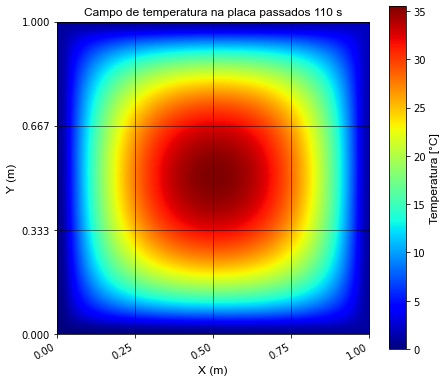

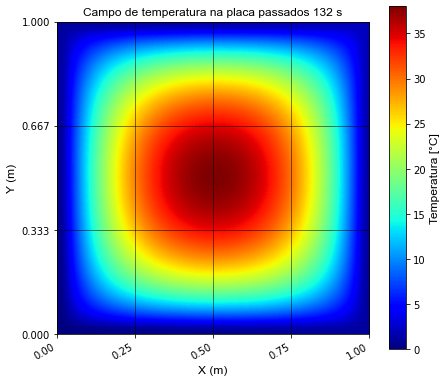

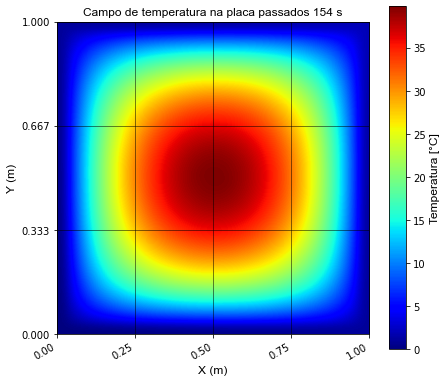

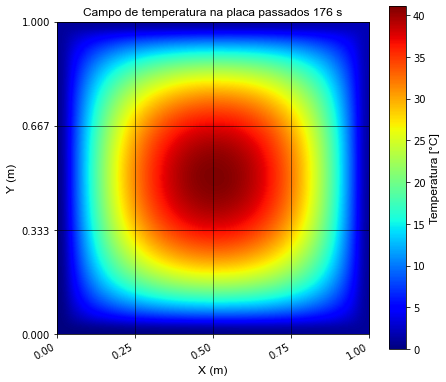

'\npoint_data = {\'Temperatura\' : T}\ndata_Tcc = {\'T_contorno\' : Tcc}\npoint_data.update(data_Tcc)\nmeshio.write_points_cells(\'solucao.vtk\',\n                          msh.points, \n                          msh.cells,\n                          file_format="vtk-ascii",\n                          point_data=point_data,\n                          )\n'

In [ ]:
Lx = 1.0
Ly = 1.0
nx = 30
ny = 30
k = 34.0
alpha = 0.0008
Q = 20000.0   # fonte de calor
to = 0
tf = 180
dt = 1
nt = int((tf-to)/dt+1)


beta = 1.0 # implicito
#beta = 0.0 # explicito
#beta = 0.5 # Crank-Nicolson

# Geração de:
## pontos

nVerts = nx*ny

nVerts_array = np.empty(nVerts, dtype='int')

#criando lista de todos os pontos
for i in range(0,nVerts):
    nVerts_array[i] = i

## elementos
ne = 2*(nx-1)*(ny-1) # triangulo
IEN = np.zeros( (ne,3),dtype='int' )   #Empty IEN

Xv = np.linspace(0,Lx,nx)
Yv = np.linspace(0,Ly,ny)
X,Y = np.meshgrid(Xv,Yv)   #Gera matrizes (ny,nx)
X = np.reshape(X,nVerts)
Y = np.reshape(Y,nVerts)

TRI = Delaunay(np.column_stack((X,Y)))   #np.column_stack torna vetores colunas de uma matriz
IEN = TRI.simplices.copy()               #o método simplices retorna a IEN da malha gerado pelo Delaunay
numElems = IEN.shape[0]

bound1 = []
bound2 = []
bound3 = []
bound4 = []

for i in range(0,nx):           #lado inferior          #    x x x x x x x
    bound1.append(i)                                    #    y           y
for i in range(2,ny):           #lado direito           #    y           y
    bound2.append(i*nx - 1)                             #    y           y
for i in nVerts_array[-nx:]:    #lado superior          #    y           y
    bound3.append(i)                                    #    y           y
for i in range(1,ny-1):         #lado esquerdo          #    x x x x x x x
    bound4.append(i*nx)

Tcc = np.zeros( (nVerts),dtype='float' )

# caso sejam dirichlet:         # veja que variam com o espaço
for i in bound1:                #lado inferior 
    Tcc[i] = X[i]
    #Tcc[i] = 30 


for i in bound2:                #lado direito
    Tcc[i] = Y[i]*Y[i] + 1
    #Tcc[i] = 25

# cc3 (caso seja dirichlet)
for i in bound3:                #lado superior
    Tcc[i] = X[i]*X[i] + 1
    #Tcc[i] = 30

# cc4 (caso seja dirichlet)
for i in bound4:                #lado esquerdo
    Tcc[i] = Y[i]
    #Tcc[i] = 90

IENbound = bound1 + bound2 + bound3 + bound4
todos = list(range(0,nVerts))
miolo = [i for i in todos if i not in IENbound]

# vetor de áreas de cada elemento
area = np.empty(ne)
e = 0
for i in range(0,ny-1):
    for j in range(0,nx-1):

        lado1 = np.array([ X[i*nx+j+nx]-X[i*nx+j], Y[i*nx+j+nx]-Y[i*nx+j] ])
        lado2 = np.array([ X[i*nx+j+1]-X[i*nx+j], Y[i*nx+j+1]-Y[i*nx+j] ])
        diagonal = np.array([ X[i*nx+j+nx+1]-X[i*nx+j], Y[i*nx+j+nx+1]-Y[i*nx+j] ])

        A_tri1 = np.linalg.norm(np.cross(lado1,diagonal))/2
        area[e] = A_tri1
        e += 1

        A_tri2 = np.linalg.norm(np.cross(lado2,diagonal))/2
        area[e] = A_tri2
        e += 1

# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (nVerts,nVerts),dtype='float' )
M = np.zeros( (nVerts,nVerts),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 kb1 = Y[v2]-Y[v3]
 kb2 = Y[v3]-Y[v1]
 kb3 = Y[v1]-Y[v2]
 
 kc1 = X[v3]-X[v2]
 kc2 = X[v1]-X[v3]
 kc3 = X[v2]-X[v1]

 kxelem = np.array([[kb1*kb1,kb1*kb2,kb1*kb3],
                    [kb2*kb1,kb2*kb2,kb2*kb3],
                    [kb3*kb1,kb3*kb2,kb3*kb3]])
 kyelem = np.array([[kc1*kc1,kc1*kc2,kc1*kc3],
                    [kc2*kc1,kc2*kc2,kc2*kc3],
                    [kc3*kc1,kc3*kc2,kc3*kc3]])
 kelem = alpha*((1/(4.0*area[e]))*kxelem + (1/(4.0*area[e]))*kyelem)

 melem = (area[e]/12.0)*np.array([[2.0,1.0,1.0],
                             [1.0,2.0,1.0],
                             [1.0,1.0,2.0]])
 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]

# definicao da condicao inicial
T = np.zeros( (nVerts),dtype='float' )
for i in IENbound:
 T[i] = Tcc[i]

A = K.copy()
b = np.zeros( (nVerts),dtype='float' )

# definicao do sistema linear
qvec = (alpha*Q/k)*np.ones( (nVerts),dtype='float' )

##A = M/dt + K        # metodo implicito para difusao (beta = 1)
##A = M/dt            # metodo explicito para difusao (beta = 0)
##A = M/dt + beta*K   # metodo hibrido para difusao   (beta = 0.5)

A = M/dt + beta*K

#imposicao das c.c.s de Dirichlet na matriz A
for i in IENbound:
 A[i,:] = 0.0
 A[i,i] = 1.0

# recorrência temporal

Campos_T_plot1 = np.empty((nVerts,nt))                     #para plotagem via tricontourf
Campos_T_plot2 = np.empty((ny,nx,nt))   #para plotar via imshow

for n in range(0,nt):
 ##b = (M/dt)@T + M@qvec                  # metodo implicito para difusao (beta = 1)
 ##b = (M/dt - K)@T + M@qvec              # metodo explicito para difusao (beta = 0)
 ##b = (M/dt - (1.0-beta)*K)@T + M@qvec   # metodo hibrido para difusao   (beta = 0.5)

 b = (M/dt - (1.0-beta)*K)@T + M@qvec

 # imposicao das c.c.s de Dirichlet no vetor b
 for i in IENbound:
  b[i]   = Tcc[i]

 T = np.linalg.solve(A,b)

 Campos_T_plot1[:,n] = T

 CampoTemperatura = T.reshape(ny,nx)
 Campos_T_plot2[:,:,n] = CampoTemperatura


#--------------------------------------------------
#fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# plotando malha
fig, ax1 = plt.subplots(figsize = (5,5))

triang = mtri.Triangulation(X,Y,IEN)
ax1.set_aspect('equal')
ax1.triplot(triang,'k-', linewidth=0.8)

# plotando gráfico
for n in range(0,nt,int(nt/8)):

    fig, ax2 = plt.subplots(figsize = (7,7))

    
    #triang = mtri.Triangulation(X,Y,IEN)
    #ax2.set_aspect('equal')
    #ax2.tricontourf(triang,Campos_T_plot1, interpolation='quadric', origin='lower', cmap=cm.jet)
    #cbar = plt.colorbar(ax2.tricontourf(triang,Campos_T_plot1,cmap=cm.jet),shrink=1.0, aspect=20)
    

    T = Campos_T_plot2[:,:,n]
    surf = ax2.imshow(T, interpolation='quadric', origin='lower',
                cmap=cm.jet, extent=(X.min(), X.max(), Y.min(), Y.max()))    # plot com imshow é melhor renderizado
    cbar = plt.colorbar(surf,shrink=1.0, aspect=20)

    tempo = n*dt

    cbar.set_label('Temperatura [°C]',fontdict=matplot_font)
    plt.title("Campo de temperatura na placa passados " + str(round(tempo,2)) + " s",fontdict=matplot_font)
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    plt.show()

#-------------------------------------------------- 
'''
point_data = {'Temperatura' : T}
data_Tcc = {'T_contorno' : Tcc}
point_data.update(data_Tcc)
meshio.write_points_cells('solucao.vtk',
                          msh.points, 
                          msh.cells,
                          file_format="vtk-ascii",
                          point_data=point_data,
                          )
'''
#--------------------------------------------------

# Mecânica dos Fluidos & Elementos Finitos

## Obtenção do campo de velocidades a partir da função corrente $\psi$

### Fluido irrotacional ($\omega_z = 0$): caso de fluidos invíscidos com convecção desprezível.

$$ \nabla^2 \psi = 0 \;\; \Rightarrow \;\; \int_{\Omega} \omega \cdot [ \nabla \cdot (\nabla \psi) ] \;\; d\Omega = 0 $$

$$ \oint_{\Gamma} \omega \nabla \psi \cdot \vec{n} \;\; d\Gamma - \int_{Ω} \nabla \omega \cdot \nabla \psi \;\; dΩ = 0  \;\; \Rightarrow \;\; - \int_{Ω} \nabla \omega \cdot \nabla \psi \;\; dΩ - \oint_{\Gamma} \omega \nabla \psi \;\; d\Gamma = 0 $$

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \left [ \int_{Ω} B_j B_i \;\; dΩ \cdot \psi_i + \int_{\Gamma} N_j B_i \;\; dΓ_q \cdot \psi_i \right ] = 0 $$

$$ v_x = \frac{\partial \psi}{\partial y} \:,\; v_y = -\frac{\partial \psi}{\partial x} $$

$$ \int_{\Omega} \omega \cdot \left [ v_x - \frac{\partial \psi}{\partial y} \right ] \; d\Omega = 0 \;,\;\; \int_{\Omega} \omega \cdot \left [ v_y + \frac{\partial \psi}{\partial x} \right ] \; d\Omega = 0 $$

$$ v_x: \;\;\; \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{Ω} N_j N_i \;\; dΩ \cdot v_{x_i} = \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{Ω} N_j B_i^y \;\; dΩ \cdot \psi_i \;\;,\;\;\; B^y = \frac{\partial N}{\partial y}$$
$$ v_y:  \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{Ω} N_j N_i \;\; dΩ \cdot v_{y_i} = -\sum_{i}^{\infty} \sum_{j}^{\infty} \int_{Ω} N_j B_i^x \;\; dΩ \cdot \psi_i \;\;,\;\;\; B^x = \frac{\partial N}{\partial x}$$

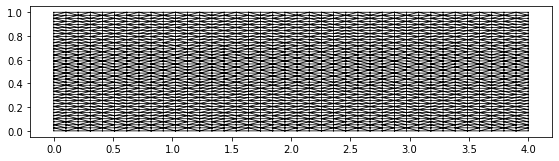

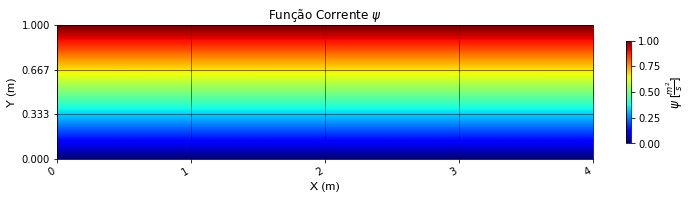

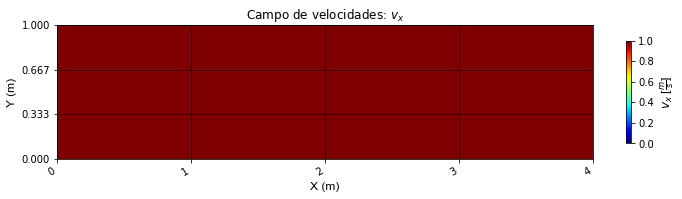

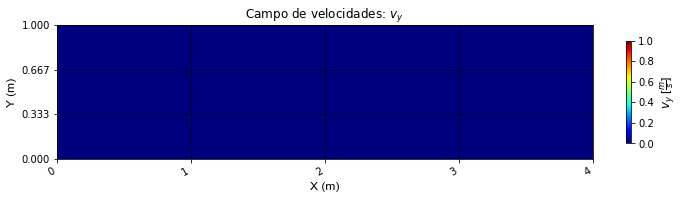

'\npoint_data = {\'Temperatura\' : T}\ndata_Tcc = {\'T_contorno\' : Tcc}\npoint_data.update(data_Tcc)\nmeshio.write_points_cells(\'solucao.vtk\',\n                          msh.points, \n                          msh.cells,\n                          file_format="vtk-ascii",\n                          point_data=point_data,\n                          )\n'

In [135]:
Lxo = 0.0
Lyo = 0.0
Lx = 4.0
Ly = 1.0
nx = 40
ny = 40

# Geração de:
## pontos

nVerts = nx*ny

nVerts_array = np.empty(nVerts, dtype='int')

for i in range(0,nVerts):   #criando lista de todos os pontos
    nVerts_array[i] = i

## elementos
ne = 2*(nx-1)*(ny-1) # triangulo
IEN = np.zeros( (ne,3),dtype='int' )   #Empty IEN

Xv = np.linspace(Lxo,Lx,nx)
Yv = np.linspace(Lyo,Ly,ny)
X,Y = np.meshgrid(Xv,Yv)   #Gera matrizes (ny,nx)
X = np.reshape(X,nVerts)
Y = np.reshape(Y,nVerts)

TRI = Delaunay(np.column_stack((X,Y)))   #np.column_stack torna vetores colunas de uma matriz
IEN = TRI.simplices.copy()               #o método simplices retorna a IEN da malha gerado pelo Delaunay
numElems = IEN.shape[0]

bound1 = []
bound2 = []
bound3 = []
bound4 = []

for i in range(0,nx):           #lado inferior          #    x x x x x x x
    bound1.append(i)                                    #    y           y
for i in range(2,ny):           #lado direito           #    y           y
    bound2.append(i*nx - 1)                             #    y           y
for i in nVerts_array[-nx:]:    #lado superior          #    y           y
    bound3.append(i)                                    #    y           y
for i in range(1,ny-1):         #lado esquerdo          #    x x x x x x x
    bound4.append(i*nx)

PSIcc = np.zeros( (nVerts),dtype='float' )

# caso sejaM dirichlet:         #veja que podem variar ao longo da fronteira
for i in bound1:                #lado inferior 
    #PSIcc[i] = X[i]
    PSIcc[i] = 0

for i in bound2:                #lado direito
    #PSIcc[i] = Y[i]*Y[i] + 1
    PSIcc[i] = ((1-0)/(Yv[-1]-Yv[0]))*Y[i] + 0 - ((1-0)/(Yv[-1]-Yv[0]))*Yv[0]
    PSIcc[i] = Y[i]
    
for i in bound3:                #lado superior
    #PSIcc[i] = X[i]*X[i] + 1
    PSIcc[i] = 1

for i in bound4:                #lado esquerdo
    PSIcc[i] = Y[i]
    #PSIcc[i] = ((1-0)/(Yv[-1]-Yv[0]))*Y[i] + 0 - ((1-0)/(Yv[-1]-Yv[0]))*Yv[0]

IENbound = bound1 + bound2 + bound3 + bound4
todos = list(range(0,nVerts))
miolo = [i for i in todos if i not in IENbound]

# vetor de áreas de cada elemento
area = np.empty(ne)
e = 0
for i in range(0,ny-1):
    for j in range(0,nx-1):

        lado1 = np.array([ X[i*nx+j+nx]-X[i*nx+j], Y[i*nx+j+nx]-Y[i*nx+j] ])
        lado2 = np.array([ X[i*nx+j+1]-X[i*nx+j], Y[i*nx+j+1]-Y[i*nx+j] ])
        diagonal = np.array([ X[i*nx+j+nx+1]-X[i*nx+j], Y[i*nx+j+nx+1]-Y[i*nx+j] ])

        A_tri1 = np.linalg.norm(np.cross(lado1,diagonal))/2
        area[e] = A_tri1
        e += 1

        A_tri2 = np.linalg.norm(np.cross(lado2,diagonal))/2
        area[e] = A_tri2
        e += 1

# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (nVerts,nVerts),dtype='float' )
M = np.zeros( (nVerts,nVerts),dtype='float' )
Gx = np.zeros( (nVerts,nVerts),dtype='float' )   #matriz do gradiente, não é usada no cálculo de psi, apenas no cálculo das velocidades 
Gy = np.zeros( (nVerts,nVerts),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area[e]))*kxelem + (1/(4*area[e]))*kyelem

 melem = (area[e]/12.0)*np.array([[2.0,1.0,1.0],
                                  [1.0,2.0,1.0],
                                  [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])

 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]

A = K.copy()

b = np.zeros( (nVerts),dtype='float' )

# imposicao das c.c.s de Dirichlet
for i in IENbound:
 A[i,:] = 0.0
 A[i,i] = 1.0
 b[i] = PSIcc[i]

PSI = np.linalg.solve(A,b)

# obtendo campo de velocidades a partir da função corrrente

bx = Gy@PSI
vx = np.linalg.solve(M,bx)

by = -Gx@PSI
vy = np.linalg.solve(M,by)

#--------------------------------------------------
# fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# plotando gráfico

'''
triang = mtri.Triangulation(X,Y,IEN)
ax2.set_aspect('equal')
ax2.tricontourf(triang,T, interpolation='quadric', origin='lower', cmap=cm.jet)
cbar = plt.colorbar(ax2.tricontourf(triang,T,cmap=cm.jet),shrink=1.0, aspect=20)
'''

## psi

fig, ax1 = plt.subplots(figsize = (12,3))

PSI = PSI.reshape(ny,nx)                                                 # plot com imshow é melhor renderizado
surf1 = ax1.imshow(PSI, interpolation='quadric', origin='lower',
            cmap=cm.jet, extent=(X.min(), X.max(), Y.min(), Y.max()))
cbar = plt.colorbar(surf1,shrink=0.7, aspect=20)

cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
plt.title("Função Corrente $\psi$")
plt.ylabel("Y (m)",fontdict=matplot_font) 
plt.xlabel("X (m)",fontdict=matplot_font) 
labx = np.linspace(X.min(),X.max(),5)
laby = np.linspace(Y.min(),Y.max(),4)
plt.grid(color='black', linestyle='solid', linewidth=0.5)
plt.xticks(labx)
plt.yticks(laby)
plt.gcf().autofmt_xdate()

## vx

fig, ax2 = plt.subplots(figsize = (12,3))

vx = vx.reshape(ny,nx)                                                 # plot com imshow é melhor renderizado
surf2 = plt.imshow(vx, interpolation='quadric', origin='lower',
            cmap=cm.jet, extent=(X.min(), X.max(), Y.min(), Y.max()))
cbar = plt.colorbar(surf2,shrink=0.7, aspect=20)

plt.clim(0,1)
cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
plt.title("Campo de velocidades: $v_x$")
plt.ylabel("Y (m)",fontdict=matplot_font) 
plt.xlabel("X (m)",fontdict=matplot_font) 
labx = np.linspace(X.min(),X.max(),5)
laby = np.linspace(Y.min(),Y.max(),4)
plt.grid(color='black', linestyle='solid', linewidth=0.5)
plt.xticks(labx)
plt.yticks(laby)
plt.gcf().autofmt_xdate()

## vy

fig, ax3 = plt.subplots(figsize = (12,3))

vy = vy.reshape(ny,nx)                                                 # plot com imshow é melhor renderizado
surf3 = plt.imshow(vy, interpolation='quadric', origin='lower',
            cmap=cm.jet, extent=(X.min(), X.max(), Y.min(), Y.max()))
cbar = plt.colorbar(surf3,shrink=0.7, aspect=20)

plt.clim(0,1)
cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
plt.title("Campo de velocidades: $v_y$")
plt.ylabel("Y (m)",fontdict=matplot_font) 
plt.xlabel("X (m)",fontdict=matplot_font) 
labx = np.linspace(X.min(),X.max(),5)
laby = np.linspace(Y.min(),Y.max(),4)
plt.grid(color='black', linestyle='solid', linewidth=0.5)
plt.xticks(labx)
plt.yticks(laby)
plt.gcf().autofmt_xdate()

plt.show()

#-------------------------------------------------- 
'''
point_data = {'Temperatura' : T}
data_Tcc = {'T_contorno' : Tcc}
point_data.update(data_Tcc)
meshio.write_points_cells('solucao.vtk',
                          msh.points, 
                          msh.cells,
                          file_format="vtk-ascii",
                          point_data=point_data,
                          )
'''
#--------------------------------------------------

### Equação de Transporte de Vorticidade para domínios bidimensionais- obtendo $\omega_z$ para inseri-lo na função corrente

$$ \frac{\partial \omega_z}{\partial t} + v \cdot \nabla \omega_z = \nu \nabla^2 \omega_z $$

Formulação fraca:

$$ \int_\Omega \left [ \frac{\partial \omega_z}{\partial t} + v \cdot \nabla \omega_z -\nu \nabla^2 \omega_z \right ] \; d\Omega = 0 $$

$$ \int_{\Omega} \omega \frac{\partial \omega_z}{\partial t} \; d\Omega + \int_{\Omega} \omega \cdot \vec{v} \cdot \nabla\omega_z \; d\Omega - \int_{\Gamma} \omega \cdot \nu \nabla\omega_z \; d\Gamma + \int_{\Omega} \nabla\omega \cdot \nu \nabla\omega_z \; d\Omega = 0 $$

Discretizando a formulação fraca:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j\omega_j \cdot \frac{\partial (N_i\omega_{z_i})}{\partial t} \; d\Omega + \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j\omega_j \cdot \vec{v} \cdot B_i\omega_{z_i} \; d\Omega - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Gamma} N_j\omega_j \cdot (\nu B_i\omega_{z_i}) \; d\Gamma + \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} B_j\omega_j \cdot (\nu B_i\omega_{z_i}) \; d\Omega = 0 $$

Dividindo a equação pela função peso $\omega$ e retirando $\omega_{z_i}$ das integrais:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j N_i \; d\Omega \cdot \frac{\partial \omega_{z_i}}{\partial t} + \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} \vec{v} \cdot N_j B_i \; d\Omega \cdot \omega_{z_i} - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Gamma} N_j \cdot (\nu B_i) \; d\Gamma \cdot \omega_{z_i} + \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} B_j \cdot (\nu B_i) \; d\Omega \cdot \omega_{z_i} = 0 $$

Substituindo os somatórios duplos por somatórios de elemento, assumindo velocidade e viscosidade constantes para o escoamento e estipulando condições de contorno de Dirichlet, a equação assume a seguinte forma: 

$$ \sum_{e}^{\infty} \int_{\Omega} N_j N_i \; d\Omega \cdot \frac{\partial \omega_{z_i}}{\partial t} + \sum_{e}^{\infty} \vec{v} \int_{\Omega} N_j B_i \; d\Omega \cdot \omega_{z_i} + \sum_{e}^{\infty} \nu \int_{\Omega} B_j B_i \; d\Omega \cdot \omega_{z_i} = 0 $$

Lembrando que as integrais das funções de interpolação correspondem a matrizes elementares de massa, gradiente e viscosidade:

$$ M^e = \int_{\Omega} N_j N_i \; d\Omega \;\;,\;\;\;\; G^e = \int_{\Omega} N_j B_i \; d\Omega \;\;,\;\;\;\; K^e = \int_{\Omega} B_j B_i \; d\Omega$$

Substituindo o somatório de matrizes elementares por suas respectivas matrizes globais:

$$ M \frac{\partial \omega_{z_i}}{\partial t} + \vec{v} \cdot G \omega_{z_i} + \nu K \omega_{z_i} = 0 $$

Finalmente, efetuando a discretização **avançada e implícita** no tempo, tem-se:

$$ M \frac{\omega_{z_i}^{n+1} - \omega_{z_i}^{n}}{\Delta t} + \vec{v} \cdot G \omega_{z_i}^{n+1} + \nu K \omega_{z_i}^{n+1} = 0 $$

$$ \left( \frac{M}{\Delta t} + \nu K + \vec{v} \cdot G \right) \omega_{z_i}^{n+1} = \frac{M}{\Delta t} \omega_{z_i}^{n} + c.c. $$

O termo de convecção ainda pode ser expandido para identificação das matrizes do gradiente nas direções x e y:

$$ \vec{v} \cdot G = (\vec{v_x} I) \cdot G_x + (\vec{v_y} I) \cdot G_y $$

Note que $\vec{v}$ corresponde a uma matriz diagonal.

$$ \left( \frac{M}{\Delta t} + \nu K + (\vec{v_x} I) \cdot G_x + (\vec{v_y} I) \cdot G_y \right) \omega_{z_i}^{n+1} = \frac{M}{\Delta t} \omega_{z_i}^{n} + c.c. $$

Com a equação acima é possível obter os valores de vorticidade para um escoamento em domínio bidimensional. Tendo-os em mãos, utiliza-se a função Equação Corrente-Vorticidade para obter a função corrente deste escoamento e, assim, em seguida obter seu campo de velocidades.

#### Domínio: retângulo livre (autoral, estruturada e uniforme)

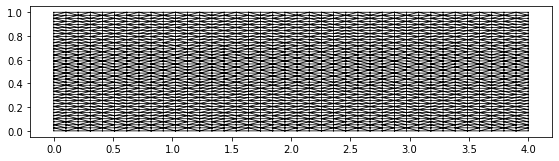

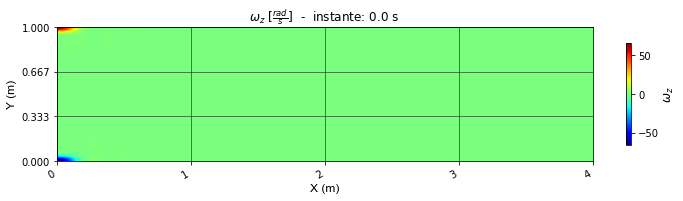

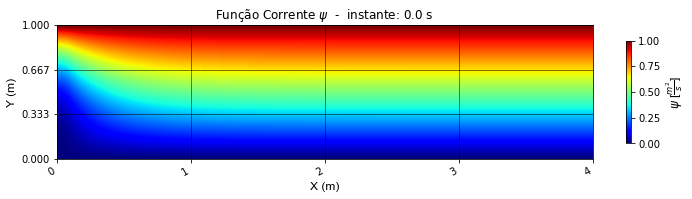

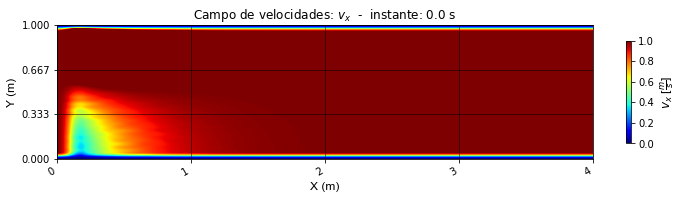

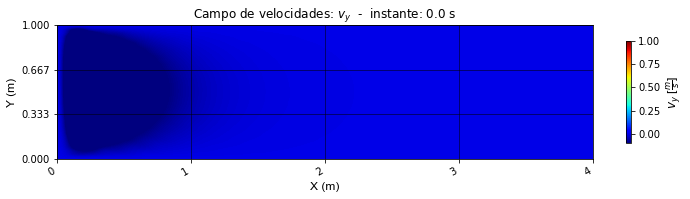

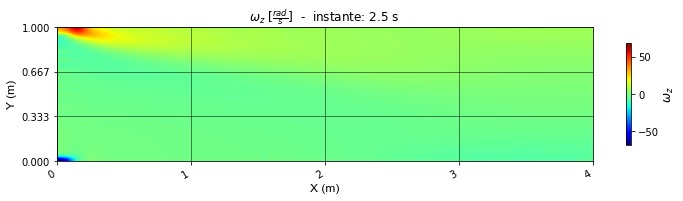

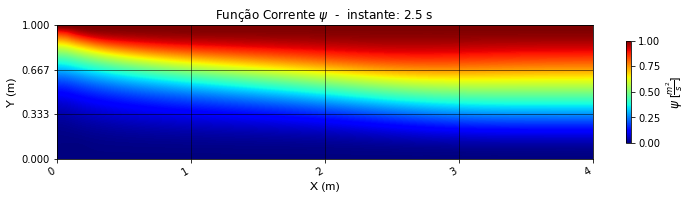

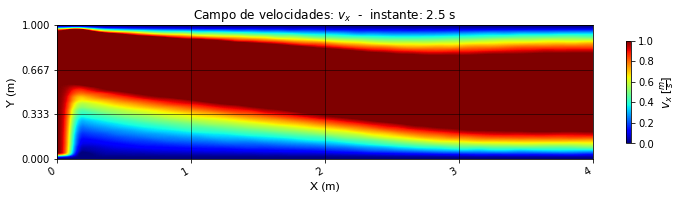

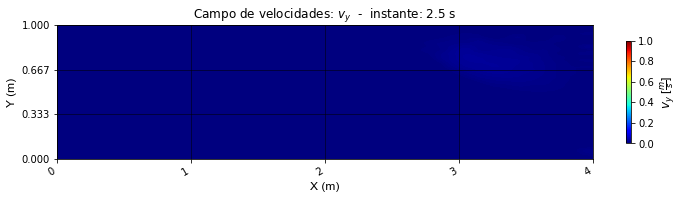

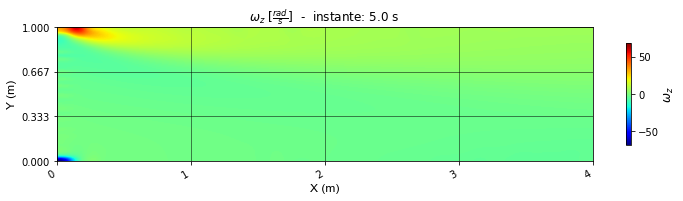

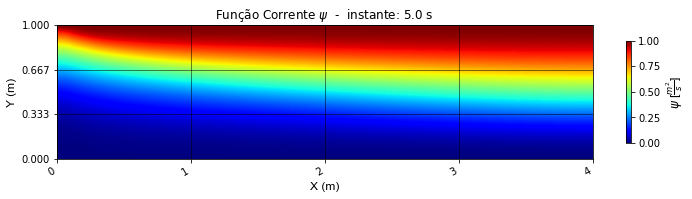

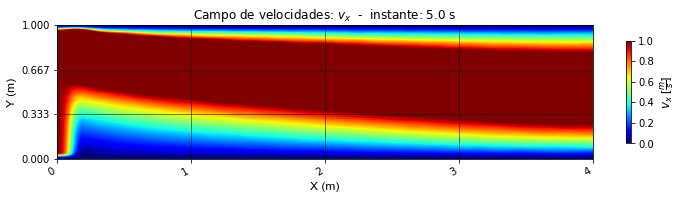

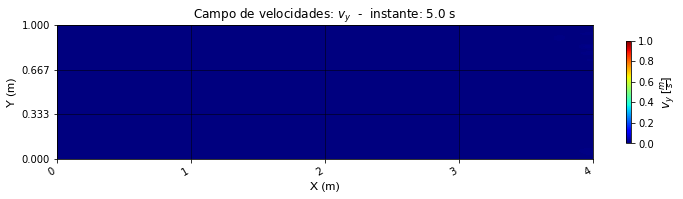

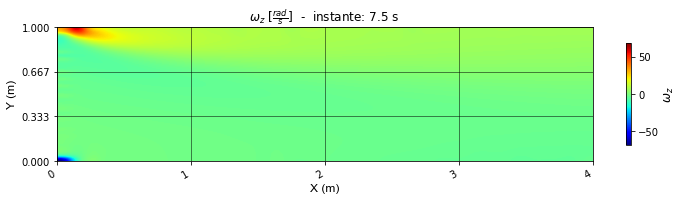

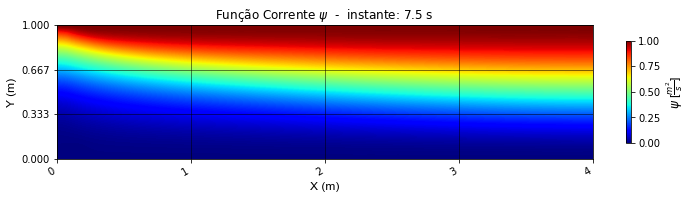

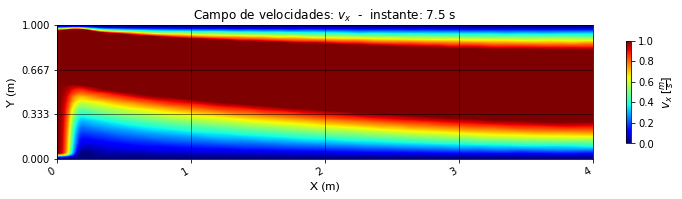

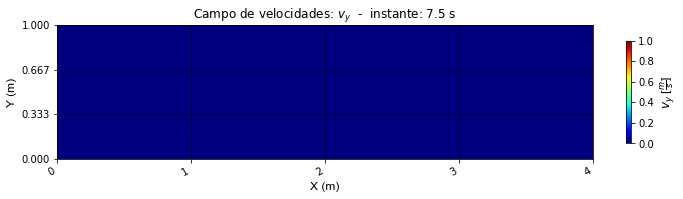

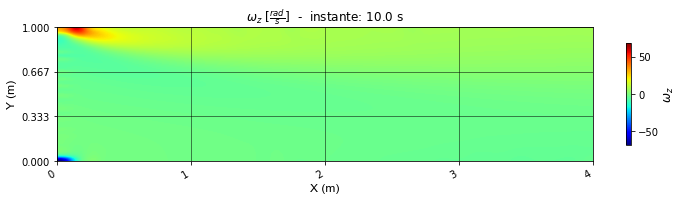

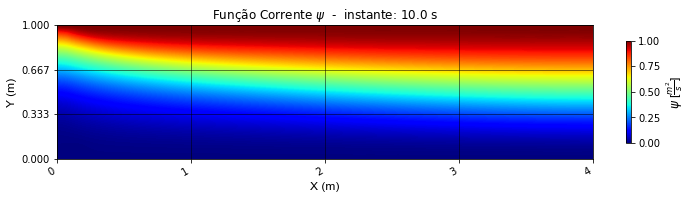

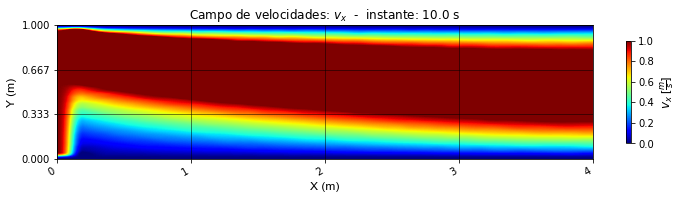

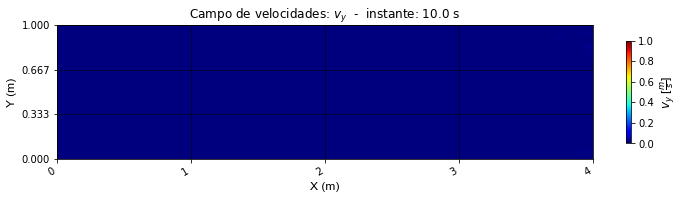

'\npoint_data = {\'Temperatura\' : T}\ndata_Tcc = {\'T_contorno\' : Tcc}\npoint_data.update(data_Tcc)\nmeshio.write_points_cells(\'solucao.vtk\',\n                          msh.points, \n                          msh.cells,\n                          file_format="vtk-ascii",\n                          point_data=point_data,\n                          )\n'

In [13]:
# Propriedades do fluido e domínio:

nu = 0.010

Lxo = 0.0
Lyo = 0.0
Lx = 4.0
Ly = 1.0
nx = 40
ny = 40

to = 0
tf = 10
dt = 0.05
nt = int((tf-to)/dt+1)

# Geração de:
## pontos

nVerts = nx*ny

## Elementos e IEN
ne = 2*(nx-1)*(ny-1) # triangulo
IEN = np.zeros( (ne,3),dtype='int' )   #Empty IEN

Xv = np.linspace(Lxo,Lx,nx)
Yv = np.linspace(Lyo,Ly,ny)
X,Y = np.meshgrid(Xv,Yv)   #Gera matrizes (ny,nx)
X = np.reshape(X,nVerts)
Y = np.reshape(Y,nVerts)

TRI = Delaunay(np.column_stack((X,Y)))   #np.column_stack torna vetores colunas de uma matriz
IEN = TRI.simplices.copy()               #o método simplices retorna a IEN da malha gerado pelo Delaunay
numElems = IEN.shape[0]

# Condições de contorno

bound1 = []
bound2 = []
bound3 = []
bound4 = []

for i in range(0,nx):           #lado inferior          #    x x x x x x x
    bound1.append(i)                                    #    y           y
for i in range(2,ny):           #lado direito           #    y           y
    bound2.append(i*nx - 1)                             #    y           y
for i in nVerts_array[-nx:]:    #lado superior          #    y           y
    bound3.append(i)                                    #    y           y
for i in range(1,ny-1):         #lado esquerdo          #    x x x x x x x
    bound4.append(i*nx)

PSIcc = np.zeros( (nVerts),dtype='float' ) 
vxcc = np.zeros( (nVerts),dtype='float' )
vycc = np.zeros( (nVerts),dtype='float' )

# caso sejaM dirichlet:         #veja que podem variar ao longo da fronteira
for i in bound1:                #lado inferior 
    #PSIcc[i] = X[i]
    PSIcc[i] = 0
    vxcc[i] = 0
    vycc[i] = 0
'''
for i in bound2:                #saída
    #PSIcc[i] = Y[i]*Y[i] + 1
    #PSIcc[i] = ((1-0)/(Yv[-1]-Yv[0]))*Y[i] + 0 - ((1-0)/(Yv[-1]-Yv[0]))*Yv[0]
'''

for i in bound3:                #lado superior
    #PSIcc[i] = X[i]*X[i] + 1
    PSIcc[i] = 1
    vxcc[i] = 0
    vycc[i] = 0

for i in bound4:                #entrada
    PSIcc[i] = Y[i]*Y[i]*Y[i]
    #PSIcc[i] = ((1-0)/(Yv[-1]-Yv[0]))*Y[i] + 0 - ((1-0)/(Yv[-1]-Yv[0]))*Yv[0]
    vxcc[i] = 1
    vycc[i] = 0

#IENbound = bound1 + bound2 + bound3 + bound4
IENbound = bound1 + bound3 + bound4

# vetor de áreas de cada elemento
area = np.empty(ne)
e = 0
for i in range(0,ny-1):
    for j in range(0,nx-1):

        lado1 = np.array([ X[i*nx+j+nx]-X[i*nx+j], Y[i*nx+j+nx]-Y[i*nx+j] ])
        lado2 = np.array([ X[i*nx+j+1]-X[i*nx+j], Y[i*nx+j+1]-Y[i*nx+j] ])
        diagonal = np.array([ X[i*nx+j+nx+1]-X[i*nx+j], Y[i*nx+j+nx+1]-Y[i*nx+j] ])

        A_tri1 = np.linalg.norm(np.cross(lado1,diagonal))/2
        area[e] = A_tri1
        e += 1

        A_tri2 = np.linalg.norm(np.cross(lado2,diagonal))/2
        area[e] = A_tri2
        e += 1

# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (nVerts,nVerts),dtype='float' )
M = np.zeros( (nVerts,nVerts),dtype='float' )
Gx = np.zeros( (nVerts,nVerts),dtype='float' )
Gy = np.zeros( (nVerts,nVerts),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area[e]))*kxelem + (1/(4*area[e]))*kyelem

 melem = (area[e]/12.0)*np.array([[2.0,1.0,1.0],
                                  [1.0,2.0,1.0],
                                  [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]

# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (nVerts),dtype='float' )
vy = np.zeros( (nVerts),dtype='float' )
PSI = np.zeros( (nVerts),dtype='float' )

for i in IENbound:
    vx[i] = vxcc[i]
    vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

CampoVort = np.empty((ny,nx,nt))
CampoPSI = np.empty((ny,nx,nt))
CampoVx = np.empty((ny,nx,nt))
CampoVy = np.empty((ny,nx,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     A[i,:] = 0.0 # zerando a linha
     A[i,i] = 1.0 # colocando 1 na diagonal
     b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,:,n] = vort.reshape(ny,nx)

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     Apsi[i,:] = 0.0
     Apsi[i,i] = 1.0
     bpsi[i] = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,:,n] = PSI.reshape(ny,nx)

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 for i in IENbound:
     vx[i] = vxcc[i]
     vy[i] = vycc[i]
 
 CampoVx[:,:,n] = vx.reshape(ny,nx)
 CampoVy[:,:,n] = vy.reshape(ny,nx)


#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

for n in range(0,nt,int(nt/4)):
    tempo = n*dt

    ## vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))

    surf0 = ax0.imshow(CampoVort[:,:,n], interpolation='quadric', origin='lower',
                cmap=cm.jet, extent=(X.min(), X.max(), Y.min(), Y.max()))           # plot com imshow é melhor renderizado
    cbar = plt.colorbar(surf0,shrink=0.7, aspect=20)

    cbar.set_label('$\omega_z$ ',fontdict=matplot_font)
    plt.title("$\omega_z$ [$\\frac{rad}{s}$]  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    surf1 = ax1.imshow(CampoPSI[:,:,n], interpolation='quadric', origin='lower',
                cmap=cm.jet, extent=(X.min(), X.max(), Y.min(), Y.max()))           # plot com imshow é melhor renderizado
    cbar = plt.colorbar(surf1,shrink=0.7, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    surf2 = plt.imshow(CampoVx[:,:,n], interpolation='quadric', origin='lower',
                cmap=cm.jet, extent=(X.min(), X.max(), Y.min(), Y.max()))           # plot com imshow é melhor renderizado
    cbar = plt.colorbar(surf2,shrink=0.7, aspect=20)

    plt.clim(0,1)
    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    surf3 = plt.imshow(CampoVy[:,:,n], interpolation='quadric', origin='lower',
                cmap=cm.jet, extent=(X.min(), X.max(), Y.min(), Y.max()))           # plot com imshow é melhor renderizado
    cbar = plt.colorbar(surf3,shrink=0.7, aspect=20)

    plt.clim(0,1)
    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

#-------------------------------------------------- 
'''
point_data = {'Temperatura' : T}
data_Tcc = {'T_contorno' : Tcc}
point_data.update(data_Tcc)
meshio.write_points_cells('solucao.vtk',
                          msh.points, 
                          msh.cells,
                          file_format="vtk-ascii",
                          point_data=point_data,
                          )
'''
#--------------------------------------------------

#### Domínio: retângulo com 1 obstáculo (via Gmsh)

C:\Users\jferreira\AppData\Local\Temp\ipykernel_24376\2806566565.py:255: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax0.tricontourf(triang,CampoVort[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_24376\2806566565.py:274: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax1.tricontourf(triang,CampoPSI[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_24376\2806566565.py:293: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax2.tricontourf(triang,CampoVx[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_24376\2806566565.py:312: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax3.tricontourf(triang,CampoVy[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)


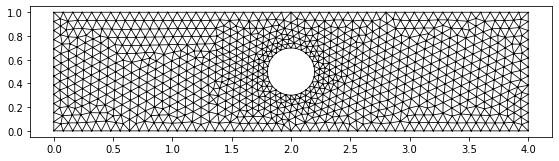

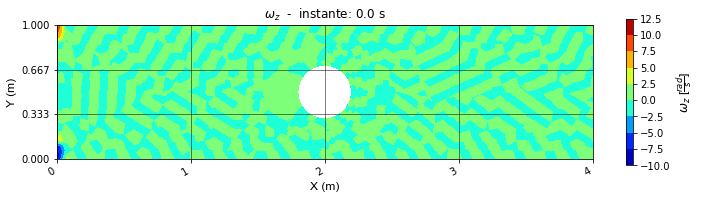

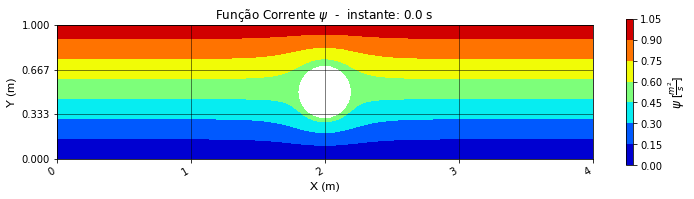

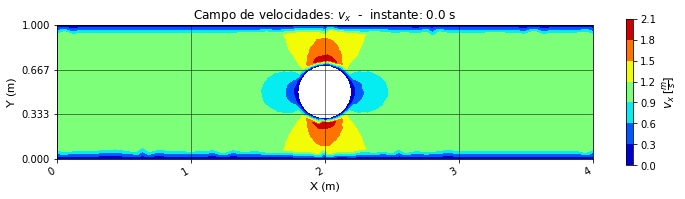

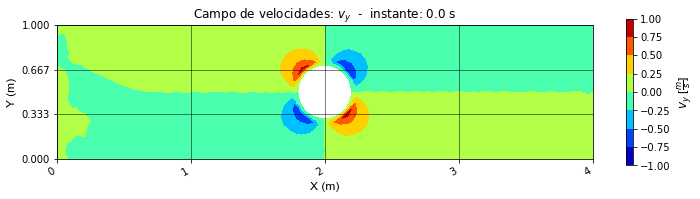

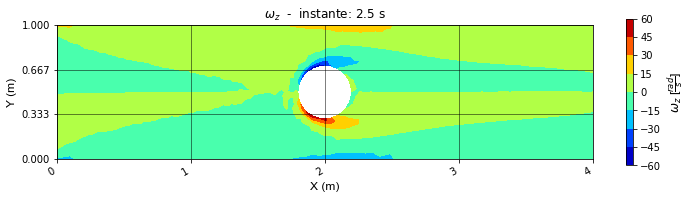

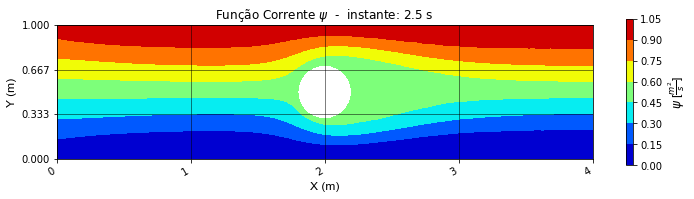

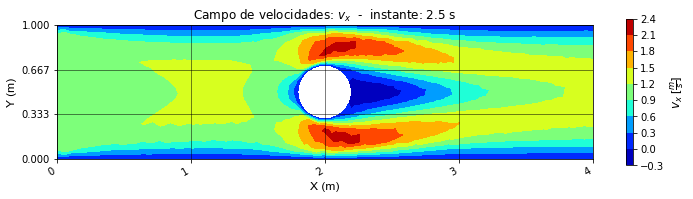

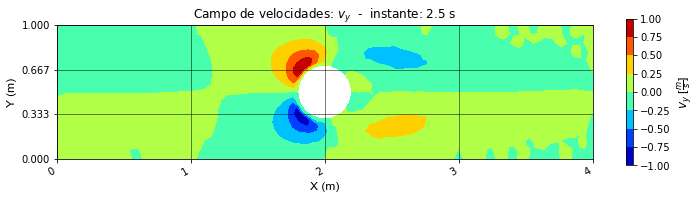

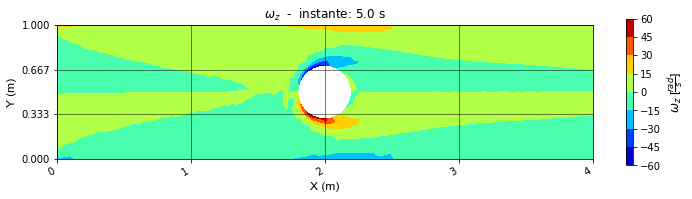

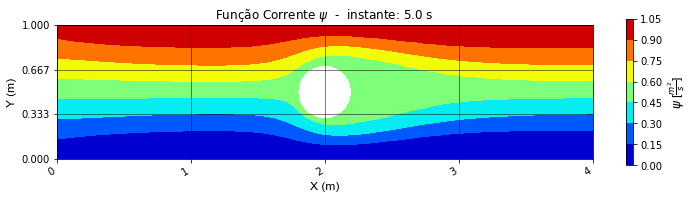

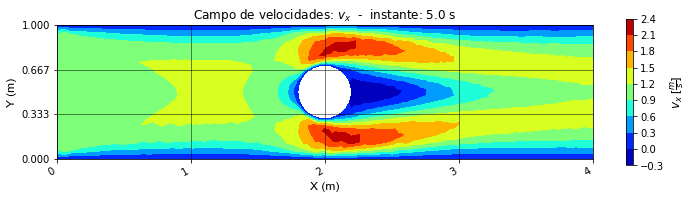

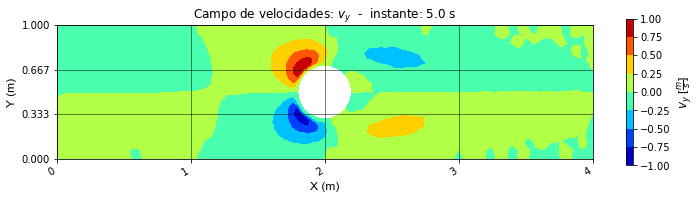

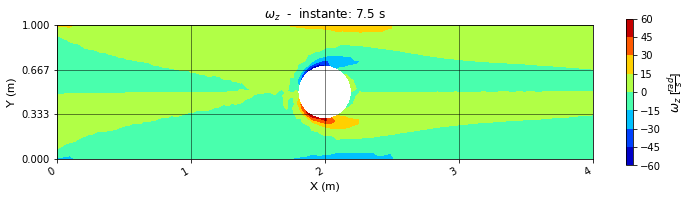

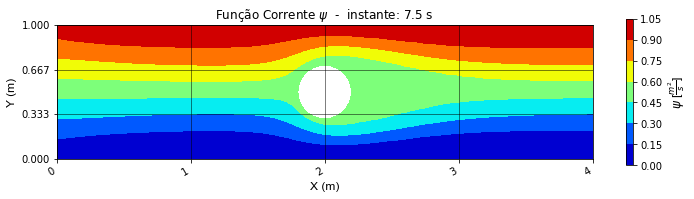

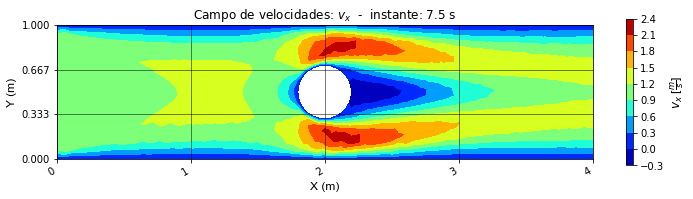

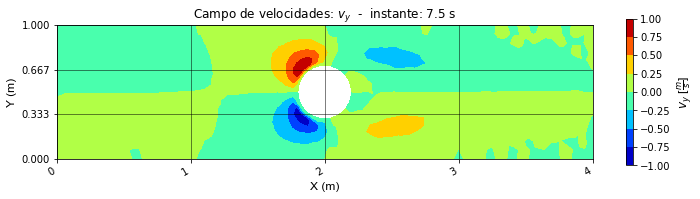

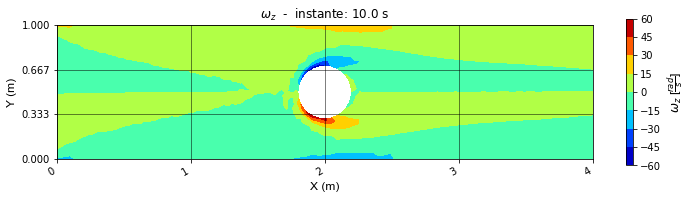

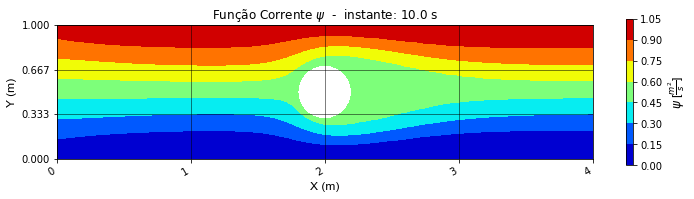

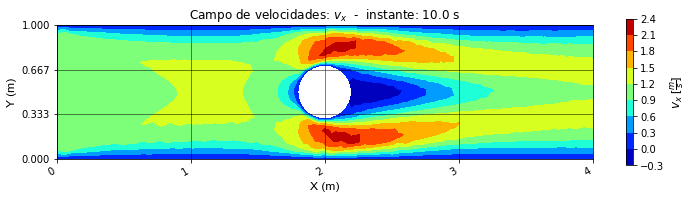

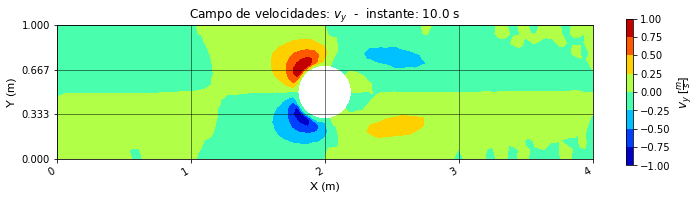

'\npoint_data = {\'Temperatura\' : T}\ndata_Tcc = {\'T_contorno\' : Tcc}\npoint_data.update(data_Tcc)\nmeshio.write_points_cells(\'solucao.vtk\',\n                          msh.points, \n                          msh.cells,\n                          file_format="vtk-ascii",\n                          point_data=point_data,\n                          )\n'

In [131]:
# Propriedades do fluido e domínio:

nu = 0.01

to = 0
tf = 10
dt = 0.05
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
#mshname = 'canal.msh'
mshname = 'cilindro.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'inlet':
  vxcc[i] = 1.0
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'paredeSup' or \
       ccName[i] == 'paredeInf' or \
       ccName[i] == 'cilindro' or \
       ccName[i] == 'inlet':
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
  if ccName[i] == 'paredeSup' or \
     ccName[i] == 'paredeInf' or \
     ccName[i] == 'cilindro' or \
     ccName[i] == 'inlet':
     vx[i] = vxcc[i]
     vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy

#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

for n in range(0,nt,int(nt/4)):
    tempo = n*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVort[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVort[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSI[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSI[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVx[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVx[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVy[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVy[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

#-------------------------------------------------- 
'''
point_data = {'Temperatura' : T}
data_Tcc = {'T_contorno' : Tcc}
point_data.update(data_Tcc)
meshio.write_points_cells('solucao.vtk',
                          msh.points, 
                          msh.cells,
                          file_format="vtk-ascii",
                          point_data=point_data,
                          )
'''
#--------------------------------------------------

#### Domínio: retângulo livre (via Gmsh, uniforme)

C:\Users\jferreira\AppData\Local\Temp\ipykernel_24376\2511594120.py:236: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax0.tricontourf(triang,CampoVort[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_24376\2511594120.py:255: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax1.tricontourf(triang,CampoPSI[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_24376\2511594120.py:274: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax2.tricontourf(triang,CampoVx[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_24376\2511594120.py:293: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax3.tricontourf(triang,CampoVy[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)


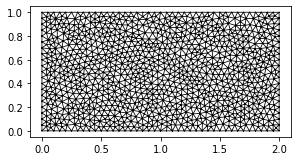

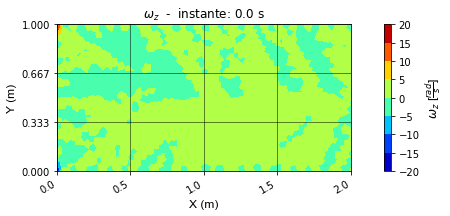

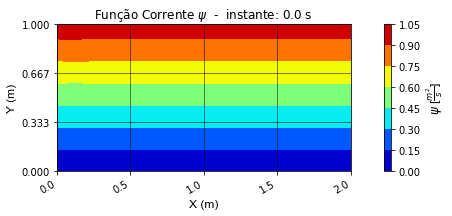

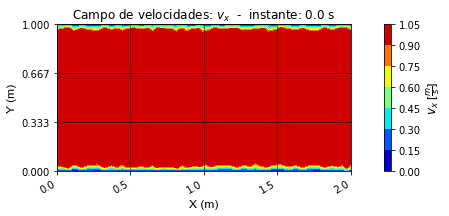

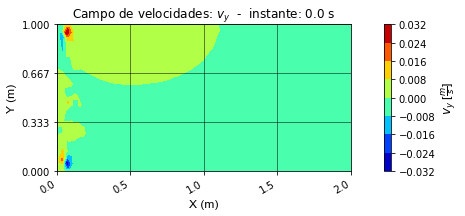

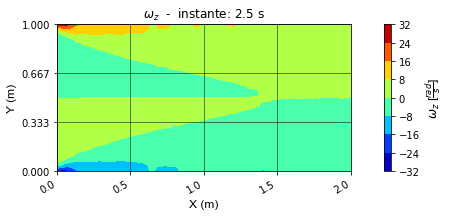

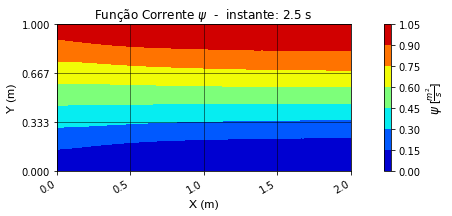

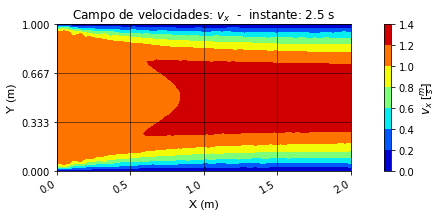

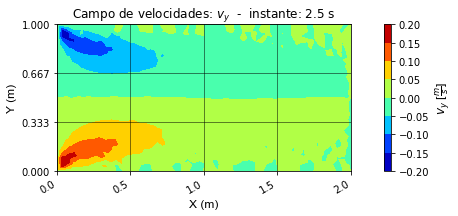

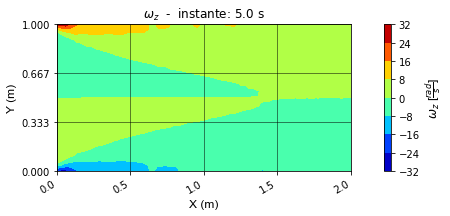

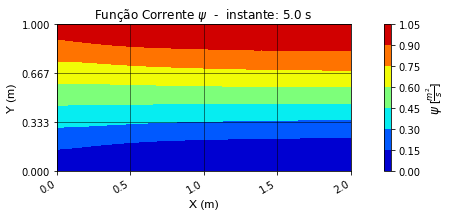

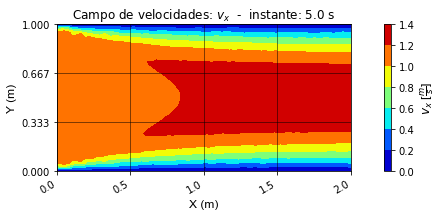

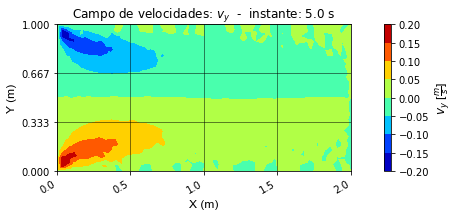

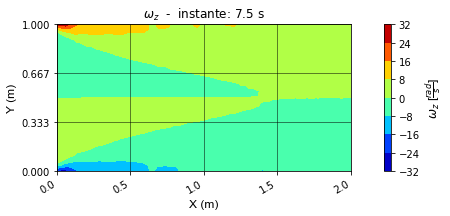

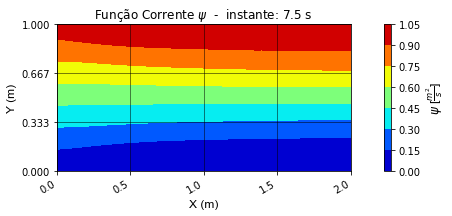

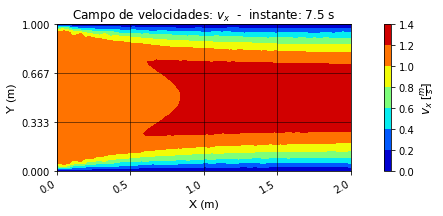

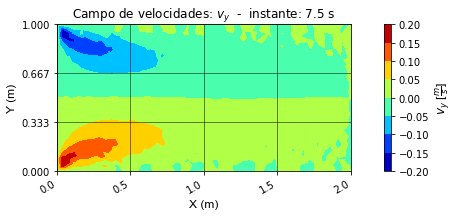

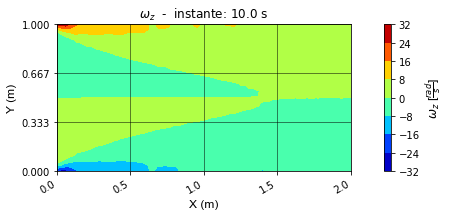

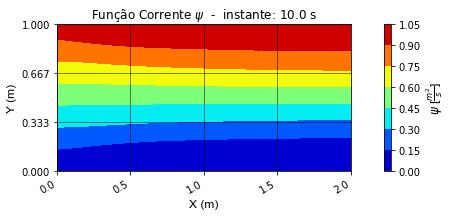

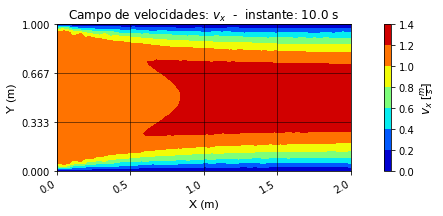

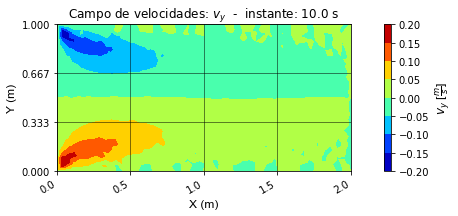

'\npoint_data = {\'Temperatura\' : T}\ndata_Tcc = {\'T_contorno\' : Tcc}\npoint_data.update(data_Tcc)\nmeshio.write_points_cells(\'solucao.vtk\',\n                          msh.points, \n                          msh.cells,\n                          file_format="vtk-ascii",\n                          point_data=point_data,\n                          )\n'

In [133]:
# Propriedades do fluido e domínio:

nu = 0.01

to = 0
tf = 10
dt = 0.05
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)

mshname = 'Retangulo.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = len(IEN)
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 5)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Admissao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Exaustao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCInferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCSuperior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'CCInferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'CCSuperior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'Admissao':
  vxcc[i] = 1.0
  vycc[i] = 0.0
  PSIcc[i] = Y[i]


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                                  [1.0,2.0,1.0],
                                  [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
        ccName[i] == 'CCInferior' or \
        ccName[i] == 'Admissao':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'CCSuperior' or \
       ccName[i] == 'CCInferior' or \
       ccName[i] == 'Admissao':
        Apsi[i,:] = 0.0 # zerando a linha
        Apsi[i,i] = 1.0 # colocando 1 na diagonal
        bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
  if ccName[i] == 'CCSuperior' or \
     ccName[i] == 'CCInferior' or \
     ccName[i] == 'Admissao':
      vx[i] = vxcc[i]
      vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy

#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

for n in range(0,nt,int(nt/4)):
    tempo = n*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVort[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVort[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSI[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSI[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVx[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVx[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVy[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVy[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

#-------------------------------------------------- 
'''
point_data = {'Temperatura' : T}
data_Tcc = {'T_contorno' : Tcc}
point_data.update(data_Tcc)
meshio.write_points_cells('solucao.vtk',
                          msh.points, 
                          msh.cells,
                          file_format="vtk-ascii",
                          point_data=point_data,
                          )
'''
#--------------------------------------------------

#### Domínio: retângulo com 1 obstáculo (via Gmsh). Resolução: integrando para obter matrizes de interpolação

In [25]:
# MATRIZ DE VISCOSIDADE ###############################################################################################

K11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K15 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K16 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K25 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K26 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K35 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K36 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K45 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K46 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]                                       

K51 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K52 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K53 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K54 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K55 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K56 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K61 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K62 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K63 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K64 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K65 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K66 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

# MATRIZ DE MASSA ###############################################################################################

M11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M15 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M16 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M25 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M26 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M35 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M36 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M45 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M46 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)                                      

M51 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M52 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M53 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M54 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M55 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M56 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M61 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M62 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M63 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M64 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M65 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M66 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

# MATRIZ DO GRADIENTE ###############################################################################################

Gx11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx15 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx16 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx25 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx26 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx35 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx36 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx45 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx46 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx51 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx52 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx53 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx54 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx55 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx56 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx61 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx62 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx63 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx64 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx65 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx66 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy15 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy16 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy25 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy26 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy35 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy36 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy45 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy46 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy51 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy52 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy53 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy54 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy55 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy56 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy61 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy62 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy63 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy64 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy65 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy66 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)


# Propriedades do fluido e domínio:

nu = 0.01

to = 0
tf = 10
dt = 0.05
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
#mshname = 'canal.msh'
mshname = 'cilindro.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'inlet':
  vxcc[i] = 1.0
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5

# Inicialização das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

## Função de integração a ser usada
def INTEGRACAO_2D_2(f,e):

  v1,v2,v3 = IEN[e]

  # Calcula a área do triângulo
  A = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                         [1.0,X[v2],Y[v2]],
                         [1.0,X[v3],Y[v3]]])

  return sp.integrate.dblquad(f,X[v1],X[v3],lambda x: (Y[v2]-Y[v1])/(X[v2]-X[v1])*x + (Y[v1]*X[v2]-Y[v2]*X[v1]),
                                            lambda x: (Y[v3]-Y[v1])/(X[v3]-X[v1])*x + (Y[v1]*X[v3]-Y[v3]*X[v1]), 
                                            (X[v1],X[v2],X[v3],Y[v1],Y[v2],Y[v3],A))[0] + \
         sp.integrate.dblquad(f,X[v3],X[v2],lambda x: (Y[v2]-Y[v1])/(X[v2]-X[v1])*x + (Y[v1]*X[v2]-Y[v2]*X[v1]),
                                            lambda x: (Y[v2]-Y[v3])/(X[v2]-X[v3])*x + (Y[v3]*X[v2]-Y[v2]*X[v3]), 
                                            (X[v1],X[v2],X[v3],Y[v1],Y[v2],Y[v3],A))[0]

## Integrando e montando
for e in range(0,ne):

  Ke = np.array([[INTEGRACAO_2D_2(K11,e),INTEGRACAO_2D_2(K12,e),INTEGRACAO_2D_2(K13,e),INTEGRACAO_2D_2(K14,e),INTEGRACAO_2D_2(K15,e),INTEGRACAO_2D_2(K16,e)],
                 [INTEGRACAO_2D_2(K21,e),INTEGRACAO_2D_2(K22,e),INTEGRACAO_2D_2(K23,e),INTEGRACAO_2D_2(K24,e),INTEGRACAO_2D_2(K25,e),INTEGRACAO_2D_2(K26,e)],
                 [INTEGRACAO_2D_2(K31,e),INTEGRACAO_2D_2(K32,e),INTEGRACAO_2D_2(K33,e),INTEGRACAO_2D_2(K34,e),INTEGRACAO_2D_2(K35,e),INTEGRACAO_2D_2(K36,e)],
                 [INTEGRACAO_2D_2(K41,e),INTEGRACAO_2D_2(K42,e),INTEGRACAO_2D_2(K43,e),INTEGRACAO_2D_2(K44,e),INTEGRACAO_2D_2(K45,e),INTEGRACAO_2D_2(K46,e)],
                 [INTEGRACAO_2D_2(K51,e),INTEGRACAO_2D_2(K52,e),INTEGRACAO_2D_2(K53,e),INTEGRACAO_2D_2(K54,e),INTEGRACAO_2D_2(K55,e),INTEGRACAO_2D_2(K56,e)],
                 [INTEGRACAO_2D_2(K61,e),INTEGRACAO_2D_2(K62,e),INTEGRACAO_2D_2(K63,e),INTEGRACAO_2D_2(K64,e),INTEGRACAO_2D_2(K65,e),INTEGRACAO_2D_2(K66,e)]])

  Me = np.array([[INTEGRACAO_2D_2(M11,e),INTEGRACAO_2D_2(M12,e),INTEGRACAO_2D_2(M13,e),INTEGRACAO_2D_2(M14,e),INTEGRACAO_2D_2(M15,e),INTEGRACAO_2D_2(M16,e)],
                 [INTEGRACAO_2D_2(M21,e),INTEGRACAO_2D_2(M22,e),INTEGRACAO_2D_2(M23,e),INTEGRACAO_2D_2(M24,e),INTEGRACAO_2D_2(M25,e),INTEGRACAO_2D_2(M26,e)],
                 [INTEGRACAO_2D_2(M31,e),INTEGRACAO_2D_2(M32,e),INTEGRACAO_2D_2(M33,e),INTEGRACAO_2D_2(M34,e),INTEGRACAO_2D_2(M35,e),INTEGRACAO_2D_2(M36,e)],
                 [INTEGRACAO_2D_2(M41,e),INTEGRACAO_2D_2(M42,e),INTEGRACAO_2D_2(M43,e),INTEGRACAO_2D_2(M44,e),INTEGRACAO_2D_2(M45,e),INTEGRACAO_2D_2(M46,e)],
                 [INTEGRACAO_2D_2(M51,e),INTEGRACAO_2D_2(M52,e),INTEGRACAO_2D_2(M53,e),INTEGRACAO_2D_2(M54,e),INTEGRACAO_2D_2(M55,e),INTEGRACAO_2D_2(M56,e)],
                 [INTEGRACAO_2D_2(M61,e),INTEGRACAO_2D_2(M62,e),INTEGRACAO_2D_2(M63,e),INTEGRACAO_2D_2(M64,e),INTEGRACAO_2D_2(M65,e),INTEGRACAO_2D_2(M66,e)]])

  Gxe = np.array([[INTEGRACAO_2D_2(Gx11,e),INTEGRACAO_2D_2(Gx12,e),INTEGRACAO_2D_2(Gx13,e),INTEGRACAO_2D_2(Gx14,e),INTEGRACAO_2D_2(Gx15,e),INTEGRACAO_2D_2(Gx16,e)],
                  [INTEGRACAO_2D_2(Gx21,e),INTEGRACAO_2D_2(Gx22,e),INTEGRACAO_2D_2(Gx23,e),INTEGRACAO_2D_2(Gx24,e),INTEGRACAO_2D_2(Gx25,e),INTEGRACAO_2D_2(Gx26,e)],
                  [INTEGRACAO_2D_2(Gx31,e),INTEGRACAO_2D_2(Gx32,e),INTEGRACAO_2D_2(Gx33,e),INTEGRACAO_2D_2(Gx34,e),INTEGRACAO_2D_2(Gx35,e),INTEGRACAO_2D_2(Gx36,e)],
                  [INTEGRACAO_2D_2(Gx41,e),INTEGRACAO_2D_2(Gx42,e),INTEGRACAO_2D_2(Gx43,e),INTEGRACAO_2D_2(Gx44,e),INTEGRACAO_2D_2(Gx45,e),INTEGRACAO_2D_2(Gx46,e)],
                  [INTEGRACAO_2D_2(Gx51,e),INTEGRACAO_2D_2(Gx52,e),INTEGRACAO_2D_2(Gx53,e),INTEGRACAO_2D_2(Gx54,e),INTEGRACAO_2D_2(Gx55,e),INTEGRACAO_2D_2(Gx56,e)],
                  [INTEGRACAO_2D_2(Gx61,e),INTEGRACAO_2D_2(Gx62,e),INTEGRACAO_2D_2(Gx63,e),INTEGRACAO_2D_2(Gx64,e),INTEGRACAO_2D_2(Gx65,e),INTEGRACAO_2D_2(Gx66,e)]])

  Gye = np.array([[INTEGRACAO_2D_2(Gy11,e),INTEGRACAO_2D_2(Gy12,e),INTEGRACAO_2D_2(Gy13,e),INTEGRACAO_2D_2(Gy14,e),INTEGRACAO_2D_2(Gy15,e),INTEGRACAO_2D_2(Gy16,e)],
                  [INTEGRACAO_2D_2(Gy21,e),INTEGRACAO_2D_2(Gy22,e),INTEGRACAO_2D_2(Gy23,e),INTEGRACAO_2D_2(Gy24,e),INTEGRACAO_2D_2(Gy25,e),INTEGRACAO_2D_2(Gy26,e)],
                  [INTEGRACAO_2D_2(Gy31,e),INTEGRACAO_2D_2(Gy32,e),INTEGRACAO_2D_2(Gy33,e),INTEGRACAO_2D_2(Gy34,e),INTEGRACAO_2D_2(Gy35,e),INTEGRACAO_2D_2(Gy36,e)],
                  [INTEGRACAO_2D_2(Gy41,e),INTEGRACAO_2D_2(Gy42,e),INTEGRACAO_2D_2(Gy43,e),INTEGRACAO_2D_2(Gy44,e),INTEGRACAO_2D_2(Gy45,e),INTEGRACAO_2D_2(Gy46,e)],
                  [INTEGRACAO_2D_2(Gy51,e),INTEGRACAO_2D_2(Gy52,e),INTEGRACAO_2D_2(Gy53,e),INTEGRACAO_2D_2(Gy54,e),INTEGRACAO_2D_2(Gy55,e),INTEGRACAO_2D_2(Gy56,e)],
                  [INTEGRACAO_2D_2(Gy61,e),INTEGRACAO_2D_2(Gy62,e),INTEGRACAO_2D_2(Gy63,e),INTEGRACAO_2D_2(Gy64,e),INTEGRACAO_2D_2(Gy65,e),INTEGRACAO_2D_2(Gy66,e)]])

  for ilocal in range(0,3):
     iglobal = IEN[e,ilocal]
     for jlocal in range(0,3):
        jglobal = IEN[e,jlocal]

        K[iglobal,jglobal] += kelem[ilocal,jlocal]
        M[iglobal,jglobal] += melem[ilocal,jlocal]
        Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
        Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'paredeSup' or \
       ccName[i] == 'paredeInf' or \
       ccName[i] == 'cilindro' or \
       ccName[i] == 'inlet':
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
  if ccName[i] == 'paredeSup' or \
     ccName[i] == 'paredeInf' or \
     ccName[i] == 'cilindro' or \
     ccName[i] == 'inlet':
     vx[i] = vxcc[i]
     vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy

#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

for n in range(0,nt,int(nt/4)):
    tempo = n*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVort[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVort[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSI[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSI[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVx[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVx[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVy[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVy[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

#-------------------------------------------------- 
'''
point_data = {'Temperatura' : T}
data_Tcc = {'T_contorno' : Tcc}
point_data.update(data_Tcc)
meshio.write_points_cells('solucao.vtk',
                          msh.points, 
                          msh.cells,
                          file_format="vtk-ascii",
                          point_data=point_data,
                          )
'''
#--------------------------------------------------

C:\Users\jferreira\AppData\Local\Temp\ipykernel_4576\2349027931.py:379: RuntimeWarning: divide by zero encountered in double_scalars
  return sp.integrate.dblquad(f,X[v1],X[v3],lambda x: (Y[v2]-Y[v1])/(X[v2]-X[v1])*x + (Y[v1]*X[v2]-Y[v2]*X[v1]),
c:\Python3.9.5\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
c:\Python3.9.5\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
c:\Python3.9.5\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (

KeyboardInterrupt: 

# Rascunho

In [21]:
# Propriedades do fluido e domínio:

nu = 0.01

to = 0
tf = 10
dt = 0.05
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
#mshname = 'canal.msh'
mshname = 'cilindro.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'inlet':
  vxcc[i] = 1.0
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5

# Inicialização das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

## Função de integração a ser usada
def INTEGRACAO_2D_2(f,e):

  v1,v2,v3 = IEN[e]

  # Calcula a área do triângulo
  A = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                         [1.0,X[v2],Y[v2]],
                         [1.0,X[v3],Y[v3]]])

  return sp.integrate.dblquad(f,X[v1],X[v3],lambda x: (Y[v2]-Y[v1])/(X[v2]-X[v1])*x + (Y[v1]*X[v2]-Y[v2]*X[v1]),
                                            lambda x: (Y[v3]-Y[v1])/(X[v3]-X[v1])*x + (Y[v1]*X[v3]-Y[v3]*X[v1]), 
                                            (X[v1],X[v2],X[v3],Y[v1],Y[v2],Y[v3],A))[0] + \
         sp.integrate.dblquad(f,X[v3],X[v2],lambda x: (Y[v2]-Y[v1])/(X[v2]-X[v1])*x + (Y[v1]*X[v2]-Y[v2]*X[v1]),
                                            lambda x: (Y[v2]-Y[v3])/(X[v2]-X[v3])*x + (Y[v3]*X[v2]-Y[v2]*X[v3]), 
                                            (X[v1],X[v2],X[v3],Y[v1],Y[v2],Y[v3],A))[0]